In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from scipy import interpolate
from time import sleep
from tqdm import tqdm
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
def Cumulative(wave):
    cu_list = []
    lists = wave.tolist()[0]
    length = len(lists)
    lists = [i**2 for i in lists]
    cu_list = [sum(lists[0:x:1]) for x in range(0, length+1)]
    return np.array(cu_list[1:])

def FindValueIndex(seq, val):
    r = np.where(np.diff(np.sign(seq - val)) != 0)
    idx = r + (val - seq[r]) / (seq[r + np.ones_like(r)] - seq[r])
    idx = np.append(idx, np.where(seq == val))
    idx = np.sort(idx)
    return np.round(idx)

def FindTOF(wave):
  Ts = 2e-7
  Threshold = 0.25
  Cum_Amp_1 = Cumulative(wave)
  Cum_Amp_1_t = np.gradient(Cum_Amp_1,Ts*1e6)
  Target_Amp = np.max(Cum_Amp_1_t)*Threshold
  index = FindValueIndex(Cum_Amp_1_t,Target_Amp).astype(int)
  TOF = next(val for x, val in enumerate(Time_response[index]) if val > 145e-6)

  return TOF*1e6

def FindTOF_longwindow(wave):
  Ts = 2e-7
  Threshold = 0.25
  Long_response = np.arange(145e-6, 225e-6+Ts/2, Ts)
  Cum_Amp_1 = Cumulative(wave)
  Cum_Amp_1_t = np.gradient(Cum_Amp_1,Ts*1e6)
  Target_Amp = np.max(Cum_Amp_1_t)*Threshold
  index = FindValueIndex(Cum_Amp_1_t,Target_Amp).astype(int)
  TOF = next(val for x, val in enumerate(Long_response[index]) if val > 154e-6)
  return TOF*1e6

# GenerateSine(Peak-peak Amplitude,frequency,cycles)
def GenerateSine(A,freq,cycles):
  t = np.linspace(0, 50e-6, 251)
  Time = np.arange(0, cycles/freq/1e3, 2e-7)
  Amp = A / 2 * np.sin(2*np.pi*freq*1e3*Time)
  Amp = np.append(Amp,np.zeros(251-len(Time)))
  return Amp

def GenerateNoisySine(A,freq,cycles,sigma):
  t = np.linspace(0, 50e-6, 251)
  Time = np.arange(0, cycles/freq/1e3, 2e-7)
  Amp = A / 2 * np.sin(2*np.pi*freq*1e3*Time)
  noise_sigma = np.std(Amp)*sigma
  Amp = np.append(Amp,np.zeros(251-len(Time)))
  Amp = Amp + np.random.normal(0,noise_sigma,len(Amp))
  return Amp

# consider the specific heat ratio
def Cal_percentage(t_A,M_B,delta_t,gas):
    if gas == 'Air':
      k_B = 1.4 # air
    elif gas == 'Argon':
      k_B = 1.66 # argon
    M_A =  4.002602 #  Gas A: helium [g/mol]
    k_A = 1.66
    M_ratio = (M_B-M_A)/M_A
    t_ratio = (t_A/(t_A+delta_t))**2
    nume = k_A * (1-t_ratio)
    denu = t_ratio*k_A*M_ratio-k_B+k_A
    percentage = nume/denu # percentage (minus means delay)
    return percentage*100
'''
def Cal_deltaTOF(con_argon,con_air):

    R = 8.314 # individual gas constant (J/mol*K)
    T = 292 # absolute temperature (K)
    L = 150 # [mm]
    t_A = L / np.sqrt(1.66*R*T/(4.002602/1e3)) * 1e3
    k_M = (1.66*(100-con_argon-con_air)+1.66*con_argon+1.4*con_air)/100
    M_M = (4.002602*(100-con_argon-con_air)+39.948*con_argon+28.966*con_air)/100/1e3 # kg/mol
    c_M = np.sqrt(k_M*R*T/M_M)
    return (L / c_M * 1e3-t_A)
'''
def Cal_deltaTOF(con_argon, con_air):
    R = 8.314  # individual gas constant (J/mol*K)
    T = 292  # absolute temperature (K)
    L = 150  # [mm]
    t_A = L / np.sqrt(1.66 * R * T / (4.002602 / 1e3)) * 1e3
    k_M = (1.66 * (100 - con_argon - con_air) + 1.66 * con_argon + 1.4 * con_air) / 100
    M_M = (4.002602 * (100 - con_argon - con_air) + 39.948 * con_argon + 28.966 * con_air) / 100 / 1e3  # kg/mol
    c_M = np.sqrt(k_M * R * T / M_M)
    return (L / c_M * 1e3 - t_A)

def CalVolume(array,time,gas):
    MFC_Helium = 0.1646 #(sl/s) / V
    MFC_Air = 118.56  #(sccm/s) / V

    interval = time / len(array)
    if gas == 'Helium':
        volume = np.trapz(array * MFC_Helium, dx=interval)
    elif gas == 'Air':
        volume = np.trapz(array * MFC_Air, dx=interval)
    return(volume)

def compute_normalized_stft(signal, fs, window_size, overlap, max_frequency):
    frequencies, times, Zxx = stft(signal, fs=fs, window='hann', nperseg=window_size, noverlap=overlap)
    magnitude = np.abs(Zxx)

    max_freq_idx = np.argmax(frequencies > max_frequency)
    magnitude = magnitude[:max_freq_idx, :]

    magnitude_db = 20 * np.log10(np.maximum(magnitude, 1e-8))
    #magnitude_min = np.min(magnitude_db)
    #magnitude_max = np.max(magnitude_db)
    #magnitude_normalized = (magnitude_db - magnitude_min) / (magnitude_max - magnitude_min)

    return magnitude_db

def find_closest_con_air(con_argon, delta_TOF_truth):
    con_air_range = np.linspace(0, 1.2, 500)
    delta_TOFs = [Cal_deltaTOF(con_argon, con_air) for con_air in con_air_range]
    idx = np.argmin(np.abs(np.array(delta_TOFs) - delta_TOF_truth))
    return con_air_range[idx]

# Data Pre-processing

Read Excitations

In [ ]:
Excitation_set = []

In [ ]:
Ts = 2e-7
Time_exci = np.arange(0, 50e-6+Ts/2, Ts)
Time_exci

In [ ]:
%cd /content/gdrive/MyDrive/AME508/Helium-Data/Training_data_pure_helium/500khz

for n in range(275):
  x = np.loadtxt('C1--Trace-Helium-15cm--00'+str(f"{n:03}")+'.csv',dtype='float32',skiprows=5,delimiter=",")
  t0_index = np.argmin(abs(x[:,0]))
  t_end = np.argmin(abs(x[:,0]-50e-6))

  interpolator = interpolate.interp1d(x[t0_index:t_end,0], x[t0_index:t_end,1],kind='linear',fill_value=0,bounds_error=False)
  Interpolated_Excitation = interpolator(Time_exci)

  Excitation_set.append(list(Interpolated_Excitation))

/content/gdrive/.shortcut-targets-by-id/194AAoMald4Ypsq8mZ7vYTSA-BHCW4Wdm/AME508/Helium-Data/Training_data_pure_helium/500khz


In [ ]:
Excitation_set = np.array(Excitation_set)

In [ ]:
np.save('Excitation_set.npy',Excitation_set)

In [ ]:
test = GenerateSine(0.4,500,10)

(0.0, 50.0)

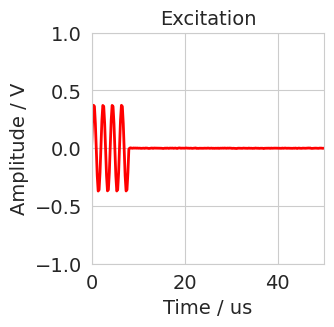

In [ ]:
from matplotlib import rcParams
plt.figure(figsize=(3,3),dpi=100)  # Figure size
mpl.rcParams.update({'font.size': 14})  # Global font size

idx = 26141

Time_plot = np.arange(0, 85e-6+Ts/2, Ts)
plt.plot(Time_plot*1e6,Response_test[idx:idx+1,426:].reshape(-1,1),linewidth=2,color='red')
#plt.plot(Time_exci*1e6,test.reshape(-1,1),linewidth=2,color='b')

plt.title('Excitation',fontsize=14)
plt.xlabel ('Time / us')
plt.ylabel ('Amplitude / V')
plt.ylim(-1,1)
plt.xlim(0,50)

Read Responses

In [ ]:
Response_set = []

In [ ]:
Time_response = np.arange(145e-6, 215e-6+Ts/2, Ts)

Time_response

In [ ]:
%cd /content/gdrive/MyDrive/AME508/Helium-Data/Training_data_pure_helium/600khz

for n in range(228):
  x = np.loadtxt('C2--Trace-Helium-15cm--00'+str(f"{n:03}")+'.csv',dtype='float32',skiprows=5,delimiter=",")

  t0_index = np.argmin(abs(x[:,0]-145e-6))
  t_end = np.argmin(abs(x[:,0]-215e-6))

  interpolator = interpolate.interp1d(x[t0_index:t_end,0], x[t0_index:t_end,1],kind='linear',fill_value=0,bounds_error=False)
  Interpolated_Response = interpolator(Time_response)

  Response_set.append(list(Interpolated_Response))

/content/gdrive/.shortcut-targets-by-id/194AAoMald4Ypsq8mZ7vYTSA-BHCW4Wdm/AME508/Helium-Data/Training_data_pure_helium/600khz


In [ ]:
Response_set = np.array(Response_set)

In [ ]:
np.save('Response_set.npy',Response_set)

(-1.0, 1.0)

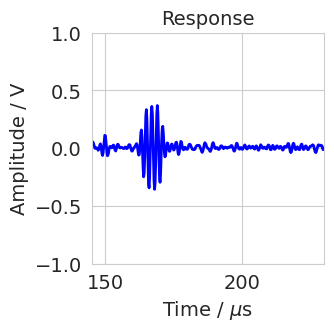

In [ ]:
plt.figure(figsize=(3,3),dpi=100)  # Figure size
mpl.rcParams.update({'font.size': 14})  # Global font size

plt.plot(Time_response*1e6,Response_test[idx:idx+1,:426].reshape(-1,1),linewidth=2,color='b')
plt.xlabel (r"Time / $\it{\mu}$s"),plt.xlim(145,230)
plt.ylabel ('Amplitude / V')
plt.title('Response',fontsize=14)
plt.ylim(-1,1)

# Load Pre-processed Data (Please RUN FROM HERE)

In [4]:
%cd /content/gdrive/MyDrive/AME508/Low-Impurity

/content/gdrive/MyDrive/AME508/Low-Impurity


In [6]:
Image_train = np.load('Image_train.npy')
Image_test = np.load('Image_test.npy')

In [5]:
Excitation_set = np.load('Input_set.npy') # 2351 is the # of samples, 251 is the length
Response_set = np.load('Response_set.npy') # 351 is the length
Concen_set = np.load('Concen_set.npy')

Ts = 2e-7 # sampling interval
Time_exci = np.arange(0, 50e-6+Ts/2, Ts)
Time_response = np.arange(145e-6, 230e-6+Ts/2, Ts)

In [7]:
# REMOVE <100mVpp
idx_to_delet = np.argwhere(np.ptp(Response_set, axis=1) < 0.2)
#idx_to_delet = np.argwhere(np.ptp(Excitation_set[:,:-2], axis=1) < 0.1)
Excitation_set = np.delete(Excitation_set,idx_to_delet,axis=0)
Response_set = np.delete(Response_set,idx_to_delet,axis=0)
Concen_set = np.delete(Concen_set,idx_to_delet,axis=0)

In [8]:
# REMOVE those random shift by equipment
idx_to_delet = np.argwhere(Excitation_set[:,0]>0.1)
Excitation_set = np.delete(Excitation_set,idx_to_delet,axis=0)
Response_set = np.delete(Response_set,idx_to_delet,axis=0)
Concen_set = np.delete(Concen_set,idx_to_delet,axis=0)

In [9]:
Ex_set_zeropad = np.pad(Excitation_set[:,:-2], ((0,0),(0,175)), 'constant')
X = np.column_stack((Response_set,Ex_set_zeropad,Concen_set))

Response_train, Response_test, Concen_train, Concen_test = train_test_split(X[:,:426*2], X[:,-2:], test_size = 0.3,random_state=42)
train_input = Response_train
train_truth = Concen_train

X_train = np.column_stack((train_input,train_truth))

np.shape(X_train)

(65011, 854)

In [ ]:
# Save the cleaned data for hari to train cGAN
np.save('Response_set_Hari.npy',Response_set)
np.save('Excitation+concentration_Hari.npy',Excitation_set)
np.save('Concentration_Only_Hari.npy',Concen_set)

(0.0, 1.3)

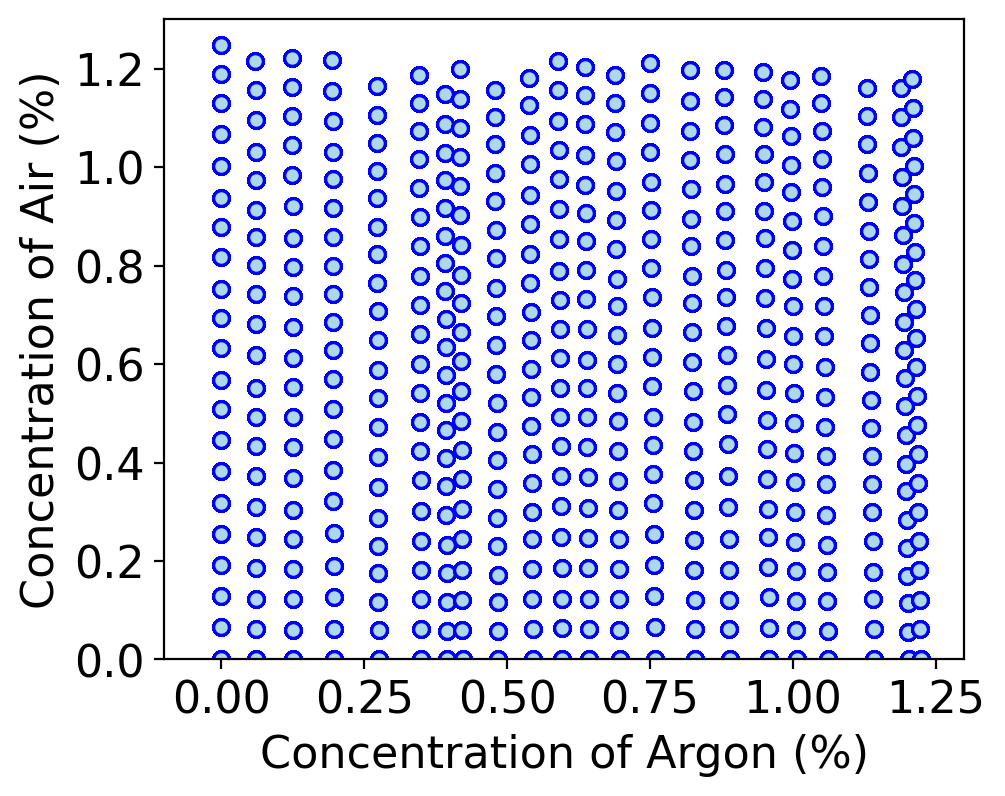

In [10]:
nc = 1
nr = 1
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig, ax  = plt.subplots(nr, nc, figsize=(5*nc, 4*nr), dpi=200)
fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)

plt.scatter(Concen_set[:, 0],Concen_set[:, 1], edgecolor='b', facecolor='lightblue', s=30)
plt.xlabel('Concentration of Argon (%)',fontsize=16)
plt.ylabel('Concentration of Air (%)',fontsize=16)
plt.xlim(-0.1,1.3)
plt.ylim(0,1.3)

In [ ]:
TOF_train = []
TOF_test = []

# Iterate through rows and apply FindTOF
for i in range(Response_train.shape[0]):
    result = FindTOF(Response_train[i:i+1, :426])
    TOF_train.append(result)

for i in range(Response_test.shape[0]):
    result = FindTOF(Response_test[i:i+1, :426])
    TOF_test.append(result)

TOF_train = np.array(TOF_train)
TOF_test = np.array(TOF_test)

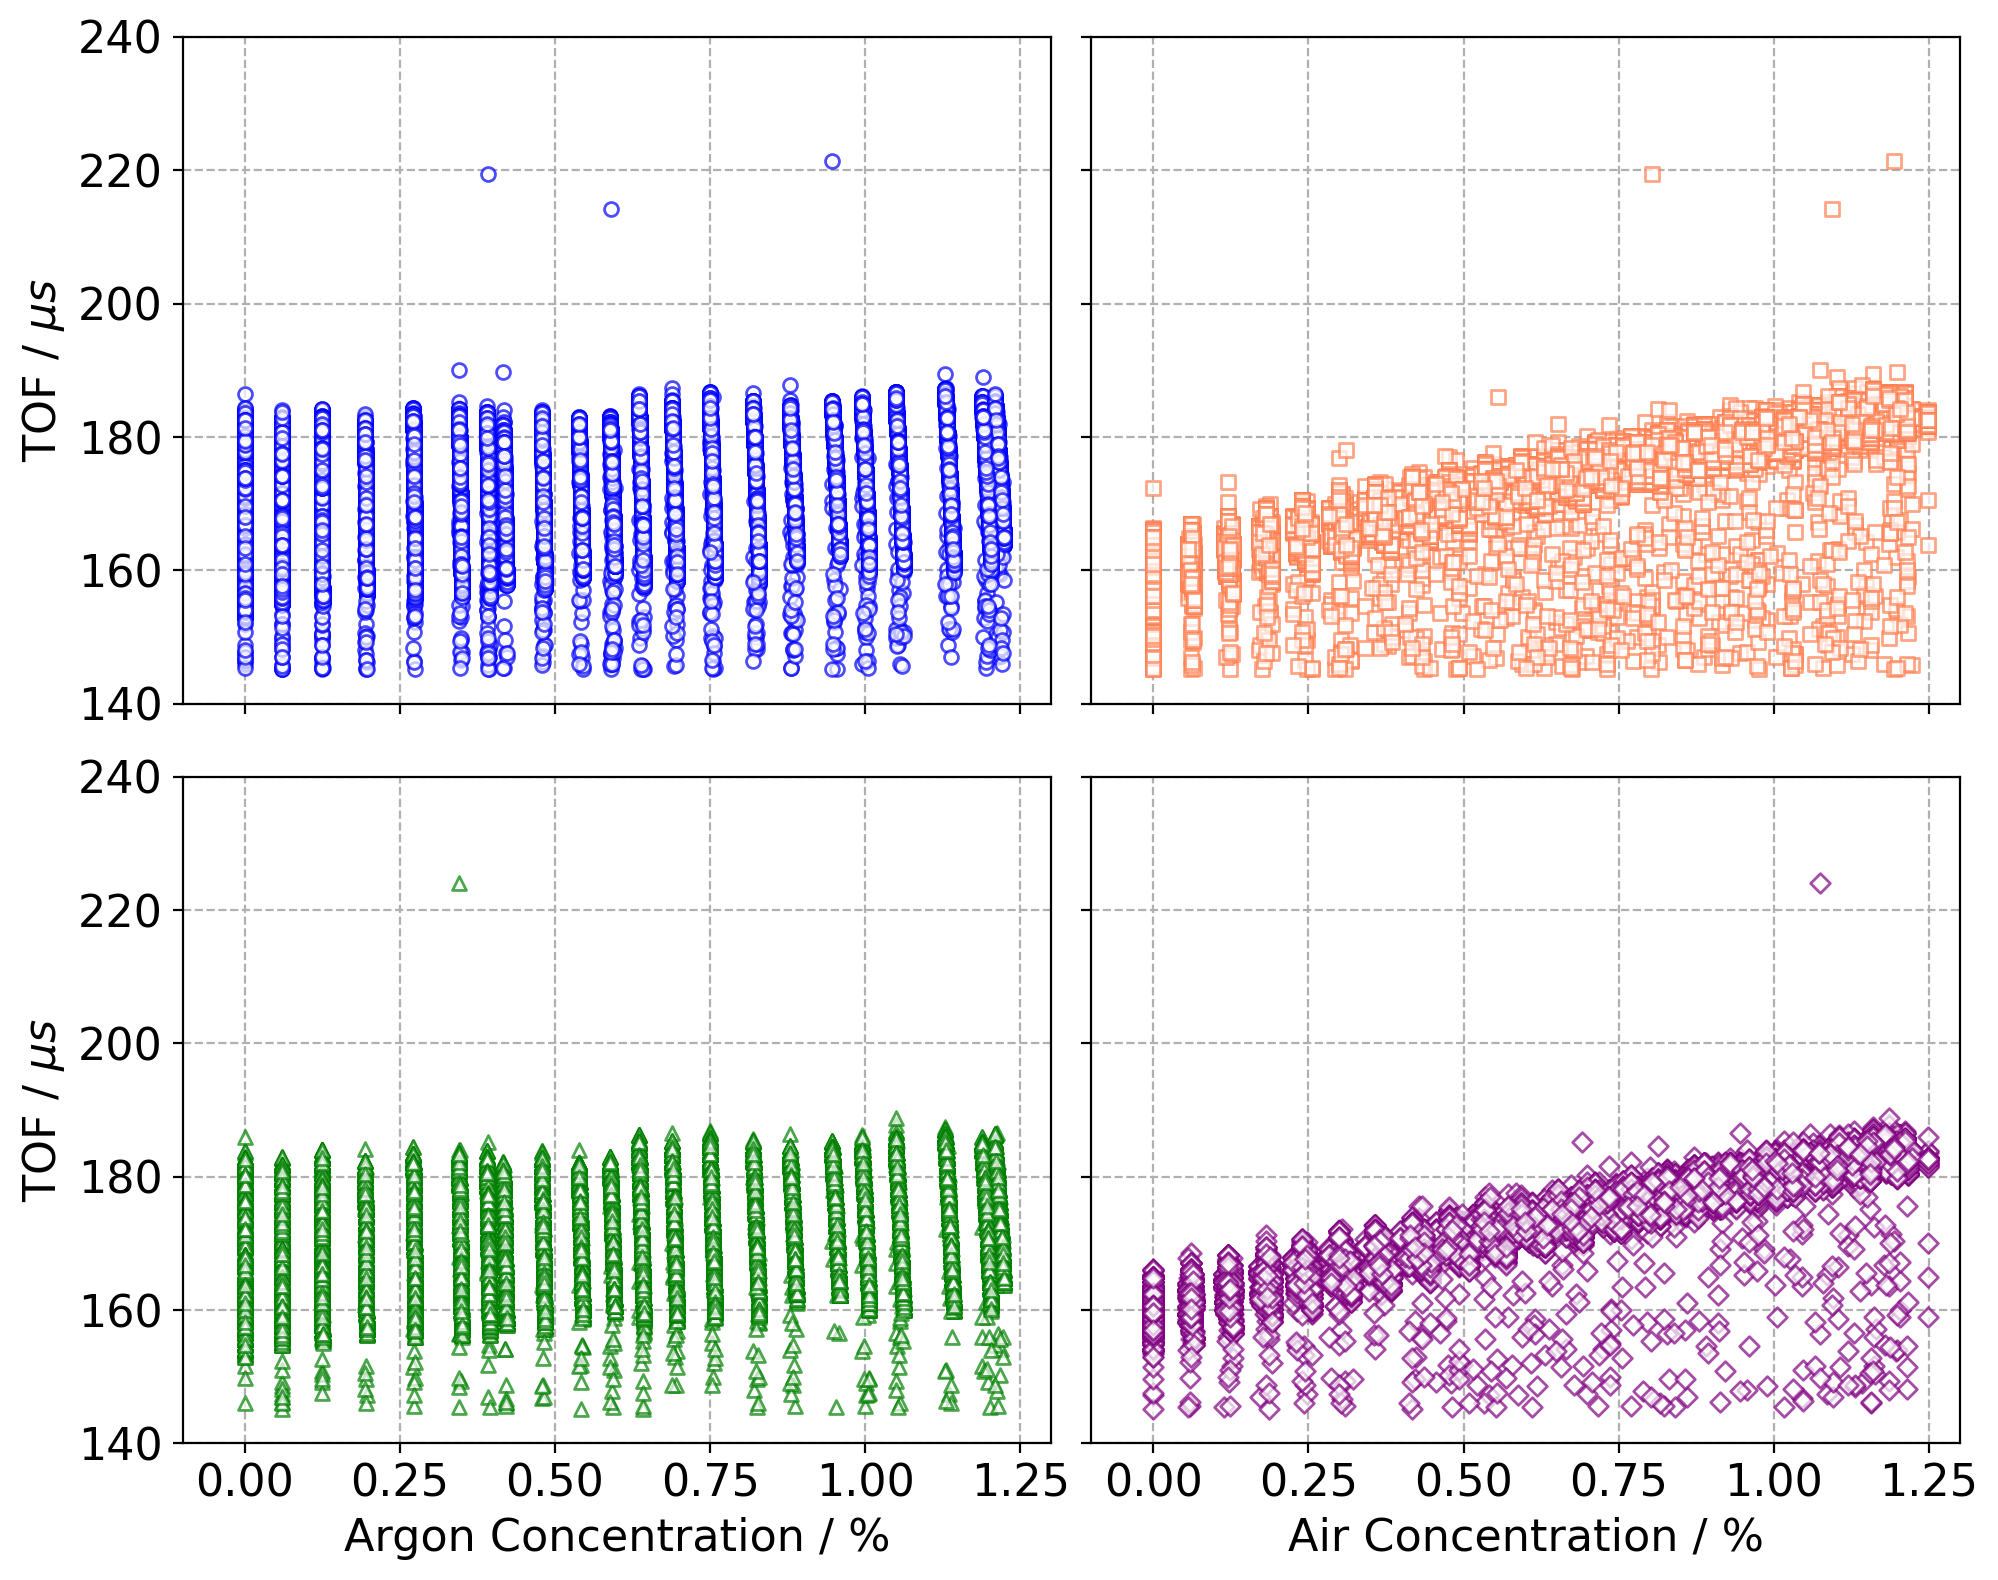

In [ ]:
nc = 2
nr = 2
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig, ax  = plt.subplots(nr, nc, figsize=(5*nc, 4*nr), dpi=200)
fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)
ax = ax.flatten()

colors = ['blue', 'coral', 'green', 'purple']
markers = ['o', 's', '^', 'D']

ax[0].scatter(train_truth[:, 0], TOF_train, color=colors[0], alpha = 0.7, marker=markers[0],facecolors='white',s=25,zorder=10)
ax[0].set_ylabel('TOF / $\mu s$',fontsize=16)
ax[0].set_xlim(-0.1, 1.3)
ax[0].set_ylim(140, 240)
ax[0].set_xticklabels([])
ax[0].grid(True,linestyle='--')

ax[1].scatter(train_truth[:, 1], TOF_train, color=colors[1], marker=markers[1], alpha = 0.7,facecolors='white',s=25,zorder=10)
ax[1].set_xlim(-0.1, 1.3)
ax[1].set_ylim(140, 240)
ax[1].set_xticklabels([]);ax[1].set_yticklabels([])
ax[1].grid(True,linestyle='--')

ax[2].scatter(Concen_test[:, 0], TOF_test, color=colors[2], marker=markers[2], alpha =0.7,facecolors='white',s=25,zorder=10)
ax[2].set_xlabel('Argon Concentration / %',fontsize=16)
ax[2].set_ylabel('TOF / $\mu s$',fontsize=16)
ax[2].set_xlim(-0.1, 1.3)
ax[2].set_ylim(140, 240)
ax[2].grid(True,linestyle='--')

ax[3].scatter(Concen_test[:, 1], TOF_test, color=colors[3], marker=markers[3], alpha = 0.7, facecolors='white',s=25,zorder=10)
ax[3].set_xlabel('Air Concentration / %',fontsize=16)
ax[3].set_xlim(-0.1, 1.3)
ax[3].set_ylim(140, 240)
ax[3].set_yticklabels([])
ax[3].grid(True,linestyle='--')

plt.tight_layout()
plt.show()

# Create custom dataset class

In [ ]:
class DataSet(torch.utils.data.Dataset):
  def __init__(self, ds):
    self.data = ds

  def __len__(self):
    return len(self.data[:,:])

  def __getitem__(self, idx):
    data = self.data[idx]
    return data

# Create dataset generator

In [ ]:
# Generators
batch_size = 640
trainingData = DataSet(X_train)
training_generator = torch.utils.data.DataLoader(trainingData,batch_size=batch_size,shuffle=True)

# Build and Train Neural Network

In [ ]:
import torch.nn.functional as F

class CNNcoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv1d(2, 4, kernel_size=3, stride=2, padding=0)
        self.conv2 = nn.Conv1d(4, 8, kernel_size=3, stride=2, padding=0)
        self.conv3 = nn.Conv1d(8, 16, kernel_size=3, stride=2, padding=0)

        self.fc1 = nn.Linear(16 * 6, 32)
        self.fc2 = nn.Linear(32, 2)

        self.pool = nn.MaxPool1d(2, stride=2)

        self.dropout = nn.Dropout(p=0.1)

    def forward(self, x):
        self.act = nn.ReLU()

        x = self.pool(self.act(self.conv1(x)))

        x = self.pool(self.act(self.conv2(x)))
        x = self.dropout(x)

        x = self.pool(self.act(self.conv3(x)))

        x = torch.flatten(x, 1)

        x = self.act(self.fc1(x))
        x = self.dropout(x)

        x = self.act(self.fc2(x))

        return x

In [ ]:
from torchsummary import summary

summary(CNNcoder(),input_size=(2,426))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 4, 212]              28
         MaxPool1d-2               [-1, 4, 106]               0
            Conv1d-3                [-1, 8, 52]             104
         MaxPool1d-4                [-1, 8, 26]               0
           Dropout-5                [-1, 8, 26]               0
            Conv1d-6               [-1, 16, 12]             400
         MaxPool1d-7                [-1, 16, 6]               0
            Linear-8                   [-1, 32]           3,104
           Dropout-9                   [-1, 32]               0
           Linear-10                    [-1, 2]              66
Total params: 3,702
Trainable params: 3,702
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.01
Estimated Total

# Training

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

# create the model
cnn = CNNcoder().to(device)

loss_fn = nn.MSELoss()
max_epochs = 200

optimizer = optim.AdamW(cnn.parameters(), lr=1e-3, betas=(0.9, 0.999),weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

train_loss = []
vali_loss = []
test_loss = []

inputs_test = torch.from_numpy(Response_test).to(torch.float32).to(device)
inputs_test = torch.reshape(inputs_test, (inputs_test.size(dim=0), 2, 426))
groundtruth_test = torch.from_numpy(Concen_test).reshape(-1,1).to(torch.float32).to(device)

for epoch in tqdm(range(max_epochs)):
  for index, data in enumerate(training_generator):

    inputs_train = data[:,:852].to(torch.float32).to(device)
    inputs_train = torch.reshape(inputs_train, (inputs_train.size(dim=0), 2, 426))
    groundtruth_train = data[:,-2:].reshape(-1,1).to(torch.float32).to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    # make prediction and evaluate loss
    prediction = cnn(inputs_train).reshape(-1,1)

    # evaluate loss
    tran_loss = loss_fn(prediction, groundtruth_train)

    # find the gradients using back-propagation
    tran_loss.backward()

    # update the weights
    optimizer.step()

  train_loss.append(tran_loss.item())

  # testing
  test_predi = cnn(inputs_test).reshape(-1,1)
  test_loss_i = loss_fn(test_predi, groundtruth_test).cpu().detach().numpy()
  test_loss_i = test_loss_i.tolist()
  test_loss.append(test_loss_i)
  scheduler.step(test_loss_i)

  print(f'The test loss: {test_loss_i}')
  sleep(0)

In [ ]:
PATH = './1D-CNN-0.2-dropout.pth'
torch.save(cnn.state_dict(), PATH)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

PATH = './1D-CNN-0.1-dropout.pth'

# create the model
cnn = CNNcoder().to(device)

cnn.load_state_dict(torch.load(PATH,map_location=torch.device('cpu')))

cpu


<All keys matched successfully>

# Visualization

In [ ]:
print(train_loss[-1])
print(test_loss[-1])

0.9828284978866577
1.243408441543579


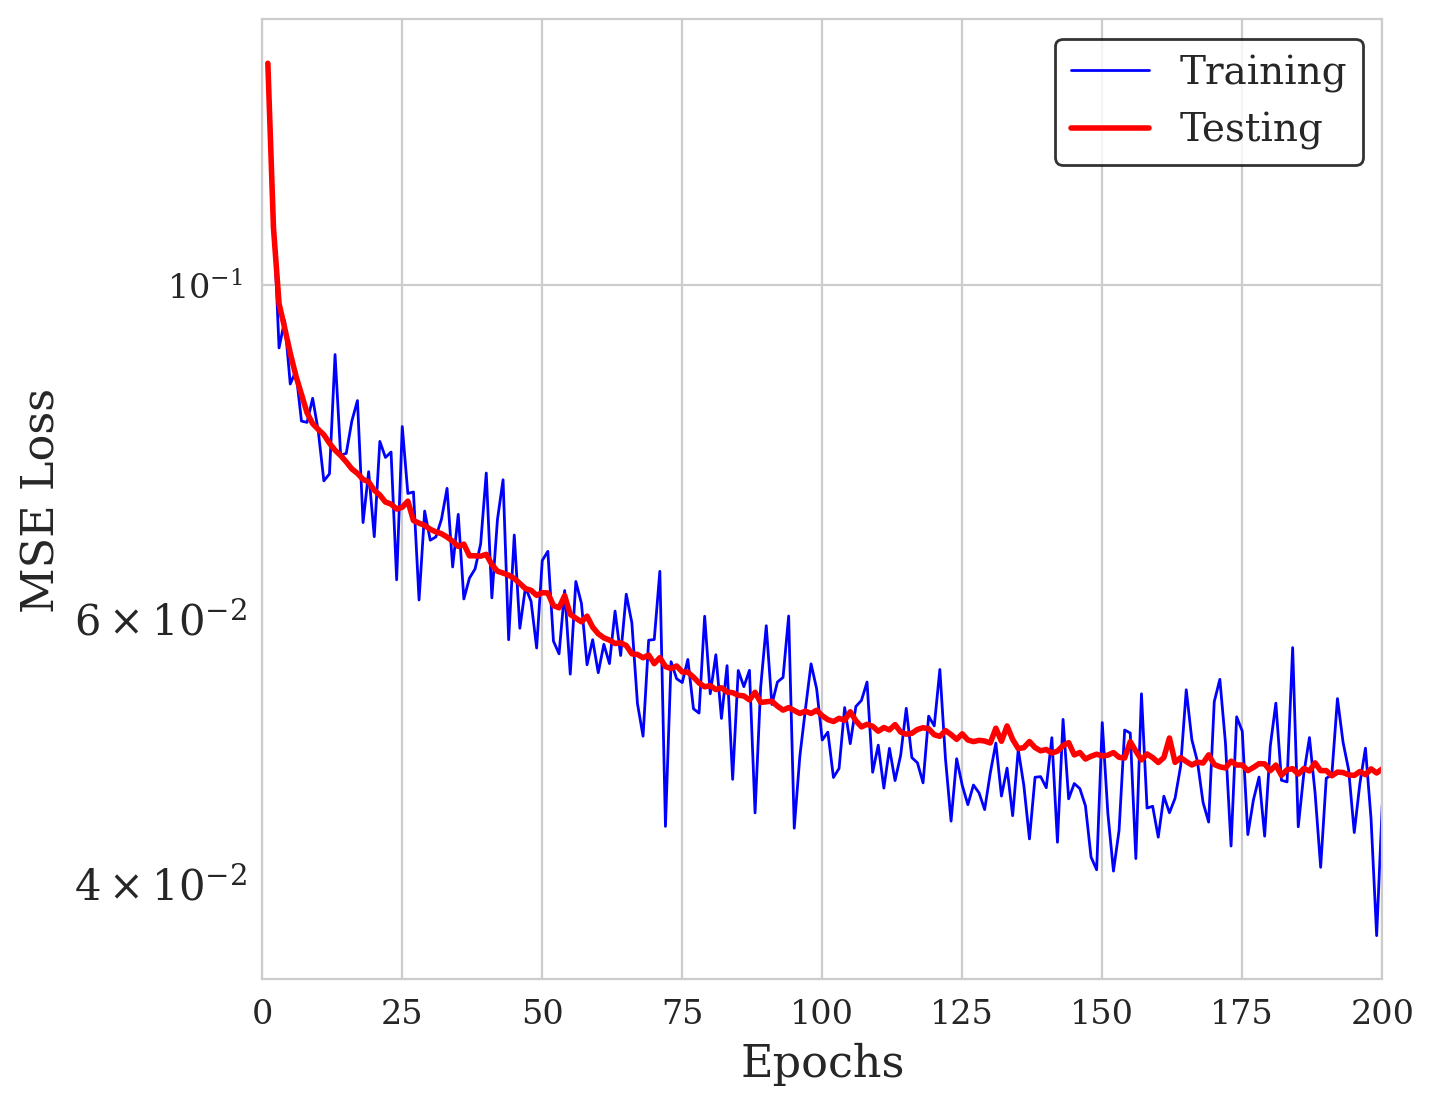

In [ ]:
nc = 1; nr = 1;
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('font',**{'family':'serif','serif':['Times']})
fig, ax  = plt.subplots(nr,nc,figsize=(7*nc,6*nr),dpi=200)
fig.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.2,hspace=0.5)

epoNum = np.arange(1,max_epochs+1)
plt.plot(epoNum,train_loss,'-b',linewidth = 1,label='Training')
#plt.plot(epoNum,vali_loss,'-k',linewidth = 2,label='Validation')
plt.plot(epoNum,test_loss,'-r',linewidth = 2,label='Testing')

ax.legend(loc='upper right',edgecolor='k',fontsize=14,frameon=True,ncol=1)
ax.set_xlabel('Epochs',fontsize=16)
ax.set_ylabel('MSE Loss',fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlim([0, max_epochs])
#ax.set_ylim([0, 10])
plt.yscale('log')
plt.rcdefaults()

In [ ]:
# plot the output vs ground truth

plot the difference on the testing set, for model p=0.1

In [ ]:
test_predi_list = []

inputs_test = torch.from_numpy(Response_test).to(torch.float32).to(device)
inputs_test = torch.reshape(inputs_test, (inputs_test.size(dim=0), 2, 426))
groundtruth_test = torch.from_numpy(Concen_test).to(torch.float32).to(device)

for run in range(500):
    with torch.no_grad():
        # Forward pass
        test_predi = cnn(inputs_test)
        test_predi_list.append(test_predi.cpu().numpy())

# Convert list of predictions to numpy array
test_predi_array = np.array(test_predi_list)

# Calculate the mean prediction over 10 runs
mean_prediction = np.mean(test_predi_array, axis=0)
std_prediction = np.std(test_predi_array, axis=0)

# Calculate the differences with groundtruth_test
diff_groundtruth = mean_prediction - groundtruth_test.cpu().numpy()

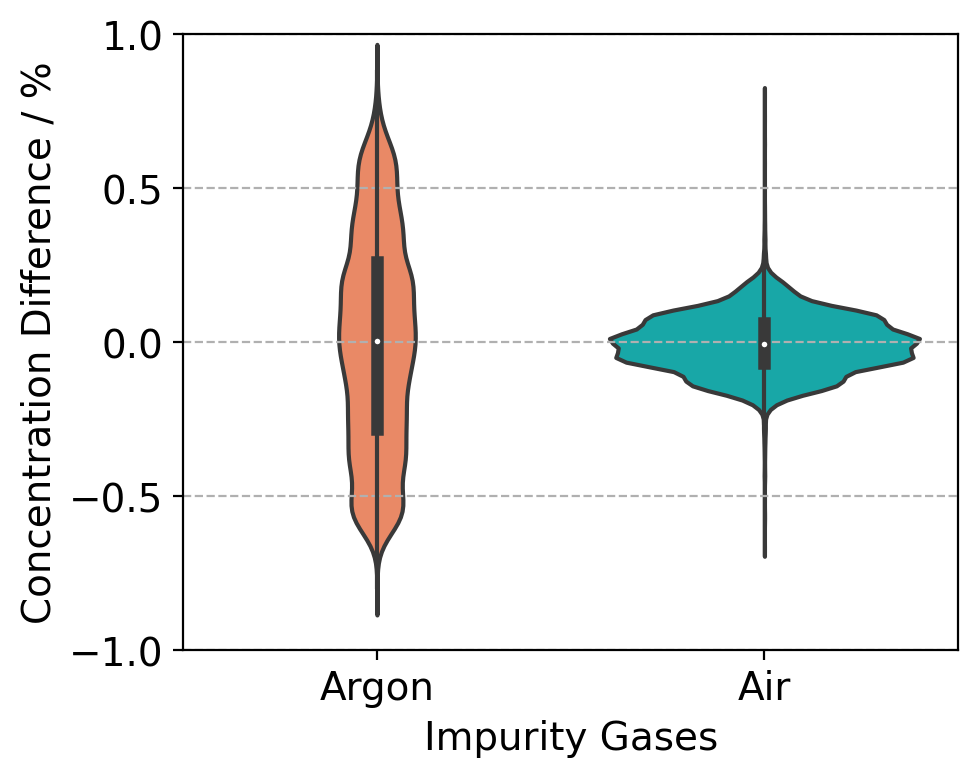

In [ ]:
Ar_difference = np.loadtxt('diff_Ar_Hari_for_Violin_plots.txt', delimiter=' ').reshape(-1,1)
Air_difference = np.loadtxt('diff_Air_Hari_for_Violin_plots.txt', delimiter=' ').reshape(-1,1)

Hari_difference = np.hstack((Ar_difference,Air_difference))

plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('font', **{'family': 'serif', 'serif': ['Times']})
fig, ax = plt.subplots(figsize=(5, 4), dpi=200)

palette = {'Argon': 'coral', 'Air': 'c'}
df = pd.DataFrame(Hari_difference, columns=['Argon', 'Air'])
df_melted = df.melt(value_name='Concentration Difference / %', var_name='Columns')

ax.grid(True, linestyle='--')
sns.violinplot(x='Columns', y='Concentration Difference / %', data=df_melted, palette=palette)
ax.set_xlabel('Impurity Gases',fontsize=14)
ax.set_ylabel('Concentration Difference / %',fontsize=14)
ax.set_ylim(-1,1)

plt.show()

(0.0, 6.0)

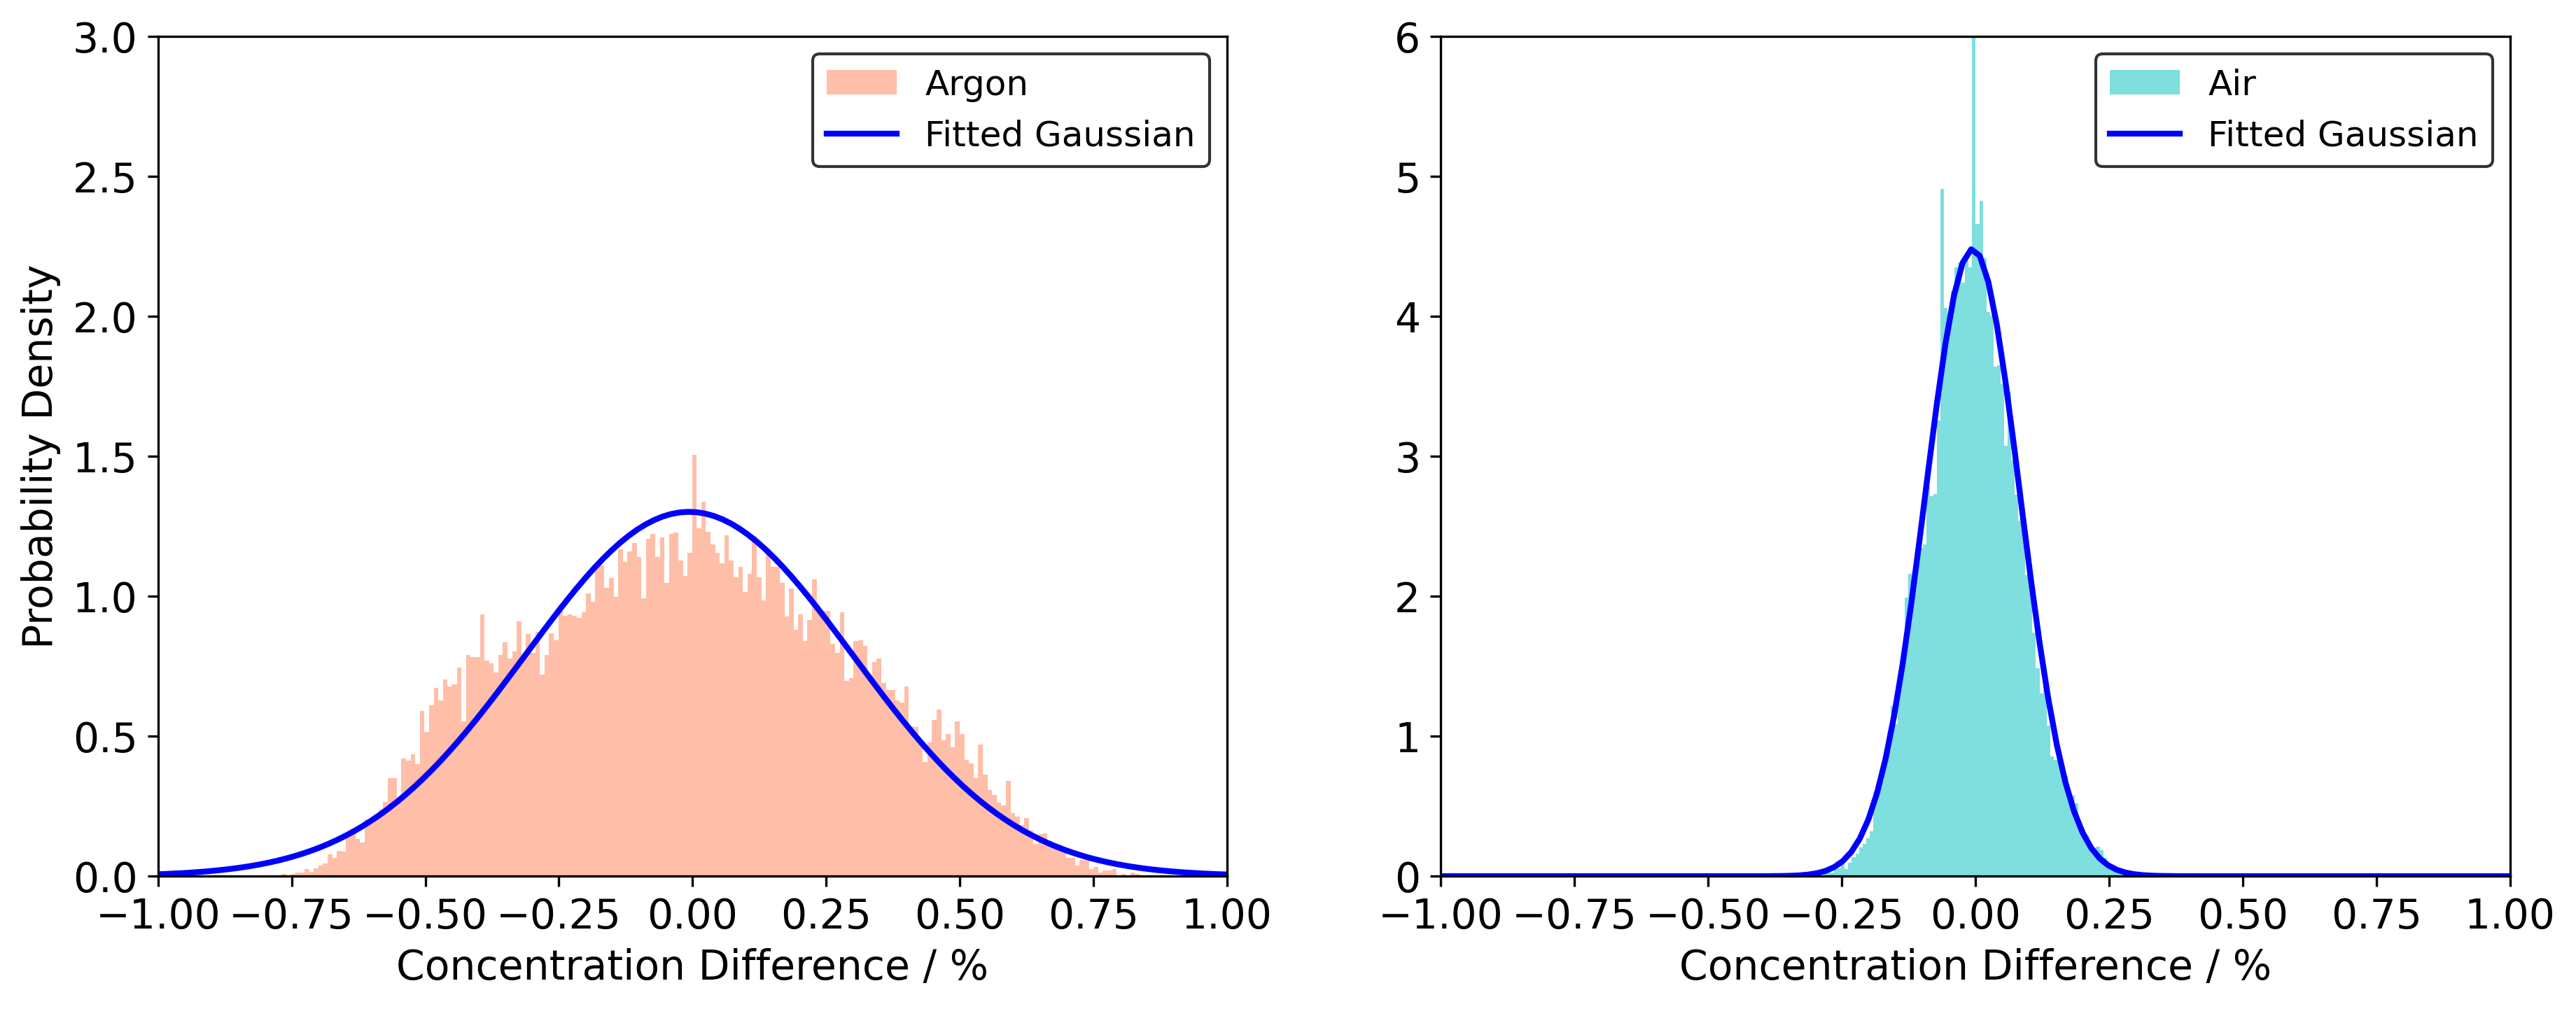

In [ ]:
from scipy.stats import norm

nr = 1
nc = 2

plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('font',**{'family':'serif','serif':['Times']})
fig, ax  = plt.subplots(nr,nc,figsize=(7*nc,5*nr),dpi=300)
fig.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.2,hspace=0.4)
ax = ax.flatten()
kwargs = dict(alpha=0.5, bins=200)

for idx in range(nr*nc):
  if idx == 0:
    ax[idx].hist(diff_groundtruth[:,0], **kwargs,color = 'coral',label='Argon',density=True)
    ax[idx].set_ylabel('Probability Density', fontsize=14)
    mu, std = norm.fit(diff_groundtruth[:,0])
    x = np.linspace(-4,4, 500)
    p = norm.pdf(x, mu, std)
    ax[idx].plot(x, p, 'b', linewidth=2,label='Fitted Gaussian')

  else:
    ax[idx].hist(diff_groundtruth[:,1], **kwargs,color = 'c',label='Air',density=True)
    mu_1, std_1 = norm.fit(diff_groundtruth[:,1])
    x_1 = np.linspace(-4,4,500)
    p_1 = norm.pdf(x_1, mu_1, std_1)
    ax[idx].plot(x_1, p_1, 'b', linewidth=2,label='Fitted Gaussian')

  ax[idx].set_xlim(-1,1)
  ax[idx].set_xlabel('Concentration Difference / %', fontsize=14)
  ax[idx].legend(loc='upper right',edgecolor='k',fontsize=12,frameon=True,ncol=1)

ax[0].set_ylim(0,3)
ax[1].set_ylim(0,6)

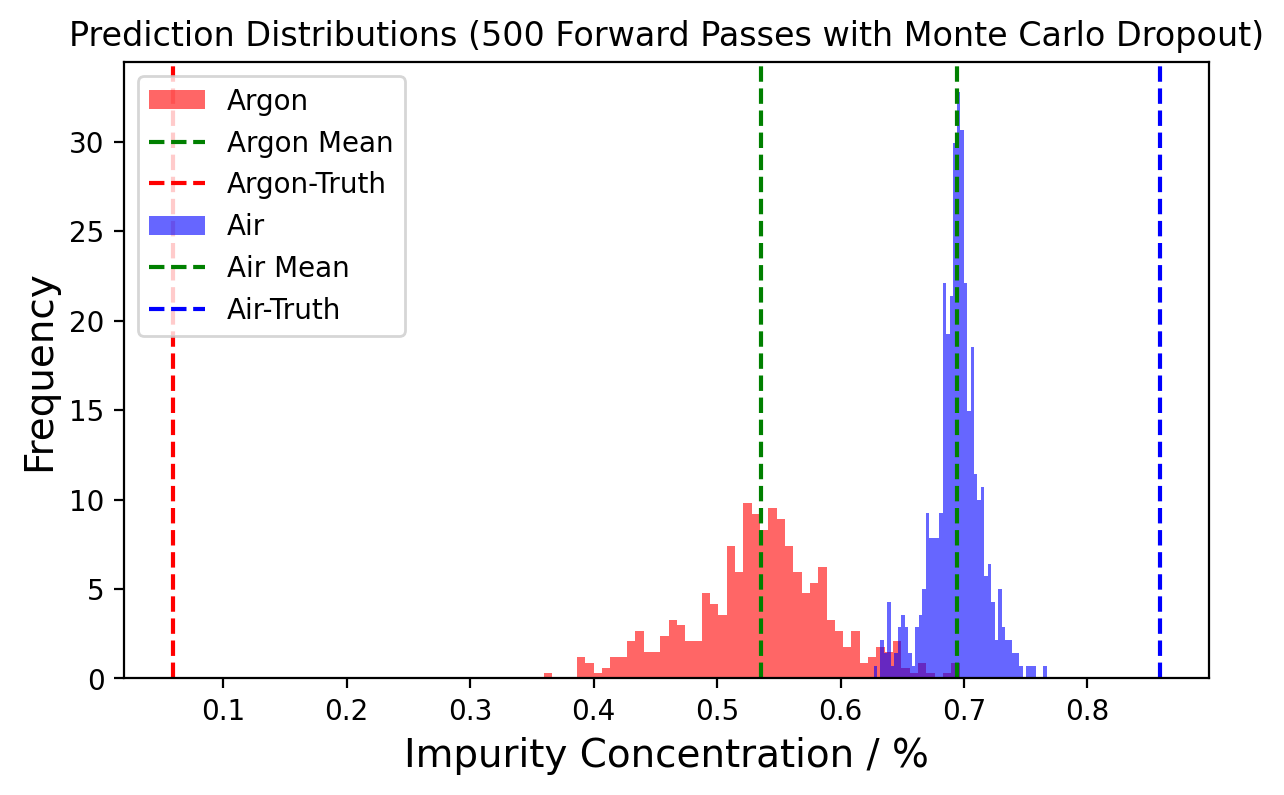

In [ ]:
plt.figure(figsize=(7,4),dpi=200)  # Figure size

Wave_idx = 1200
num_forward_passes = 500
test_wave = Response_test[Wave_idx:Wave_idx+1, :]
predictions = []
truth = Concen_test[Wave_idx:Wave_idx+1,:]

cnn.train()  # Keep the model in training mode for testing
test = torch.from_numpy(test_wave).to(torch.float32).to(device)

for _ in range(num_forward_passes):
    test_prediction = cnn(test.reshape((1, 2, 426))).cpu().detach().numpy()
    predictions.append(test_prediction)

predictions = np.array(predictions).reshape(num_forward_passes, -1)
pre_mean = np.mean(predictions,axis=0)

# Plot the distribution for the first value
plt.hist(predictions[:, 0], bins=50, density=True, color='r', alpha=0.6, label='Argon')
plt.axvline(x=pre_mean[0], color='g', linestyle='dashed', linewidth=1.5, label='Argon Mean')
plt.axvline(x=truth[0, 0], color='r', linestyle='dashed', linewidth=1.5, label='Argon-Truth')

# Plot the distribution for the second value
plt.hist(predictions[:, 1], bins=50, density=True,color='b', alpha=0.6, label='Air')
plt.axvline(x=pre_mean[1], color='g', linestyle='dashed', linewidth=1.5, label='Air Mean')
plt.axvline(x=truth[0, 1], color='b', linestyle='dashed', linewidth=1.5, label='Air-Truth')

plt.xlabel('Impurity Concentration / %',fontsize=14)
plt.ylabel('Frequency',fontsize=14)
plt.title(f'Prediction Distributions ({num_forward_passes} Forward Passes with Monte Carlo Dropout)')
plt.legend()
plt.show()

Prediction: [0.47522977 0.1846536 ]
Truth: [[0.88905401 0.06203172]]
Index in testing set: 26141


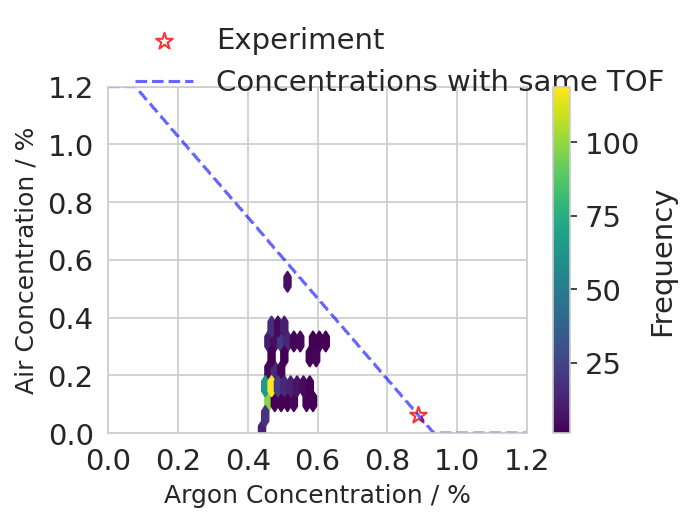

In [ ]:
plt.figure(figsize=(4.5,3),dpi=150)  # Figure size

#Hari_plot = np.array([  0,  12,  24,  36,  48,  60,  72,  84,  96, 108, 120, 132])
#Wave_idx = Hari_plot[11]

Wave_idx = np.random.randint(Response_test.shape[0])
num_forward_passes = 500
test_wave = Response_test[Wave_idx:Wave_idx+1, :]

predictions = []
truth = Concen_test[Wave_idx:Wave_idx+1, :]
cnn.train()

inputs_test = torch.from_numpy(test_wave.reshape(test_wave.shape[0], 2, 426)).to(torch.float32).to(device)

for _ in range(num_forward_passes):
    test_prediction = cnn(inputs_test).cpu().detach().numpy()
    predictions.append(test_prediction)

predictions = np.array(predictions).reshape(num_forward_passes, -1)
pre_mean = np.mean(predictions, axis=0)

print(f'Prediction: {pre_mean}')
print(f'Truth: {truth}')
print(f'Index in testing set: {Wave_idx}')

# calculate the line
delta_TOF_truth = Cal_deltaTOF(truth[0, 0], truth[0, 1])
# Generate a range of con_argon values
con_argon_values = np.linspace(0, 1.2, 500)
# Find the corresponding con_air values
con_air_values = [find_closest_con_air(con_argon, delta_TOF_truth) for con_argon in con_argon_values]

# Hexbin plot
sns.set_style("whitegrid")

hb = plt.hexbin(predictions[:, 0], predictions[:, 1], gridsize=10, cmap='viridis', mincnt=1)
plt.scatter(truth[0, 0], truth[0, 1], marker='*',s=70, color='red',facecolors='white',alpha=0.8, label='Experiment')
plt.plot(con_argon_values, con_air_values, 'b--',alpha=0.6, label='Concentrations with same TOF')

plt.xlabel('Argon Concentration / %', fontsize=12)
plt.ylabel('Air Concentration / %', fontsize=12)
plt.xlim(0,1.2)
plt.ylim(0,1.2)
plt.yticks([i for i in np.arange(0, 1.4, 0.2)])
plt.xticks([i for i in np.arange(0, 1.4, 0.2)])
plt.legend(loc='upper left',edgecolor='b',fontsize='medium',bbox_to_anchor=(0,1.25),frameon=False,ncol=1)

cb = plt.colorbar(hb, label='Frequency')
plt.show()

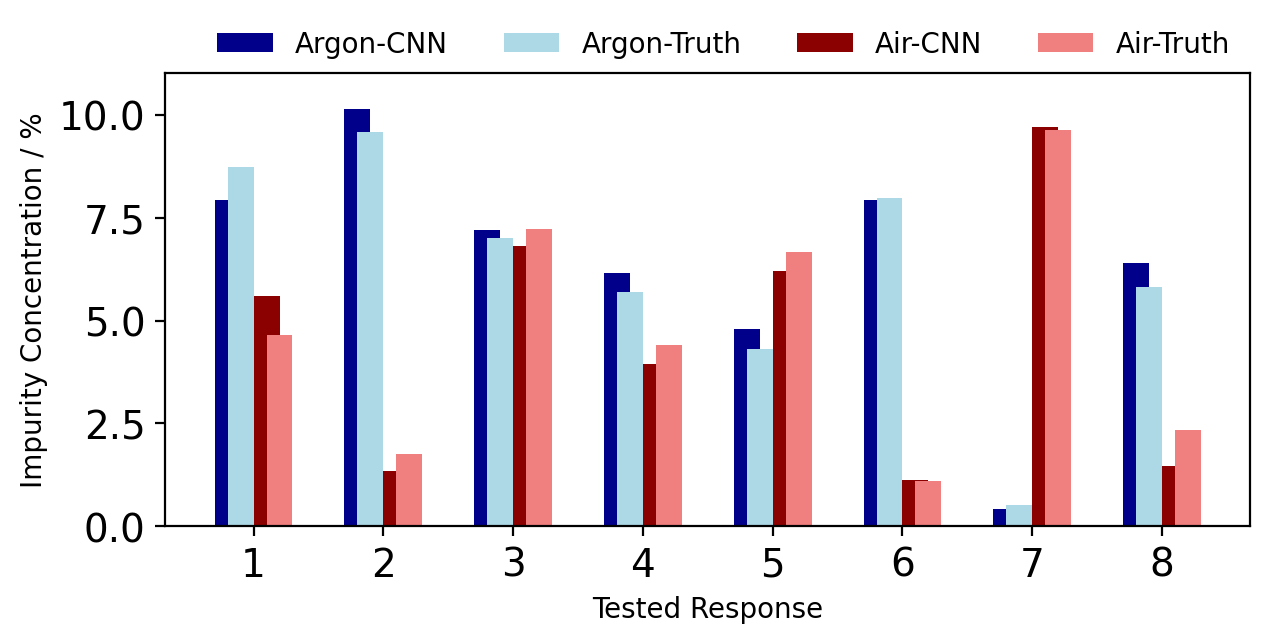

In [ ]:
truth = test_prediction = np.zeros((1,2))

for i in range(8):
  Wave_idx = np.random.randint(Response_test.shape[0])
  test_wave = Response_test[Wave_idx:Wave_idx+1,:]
  truth = np.append(truth,Concen_test[Wave_idx:Wave_idx+1,:],axis=0)

  with torch.no_grad():
    test = torch.from_numpy(test_wave).to(torch.float32).to(device)
    test_prediction = np.append(test_prediction,cnn(test.reshape((1,2,776))).cpu().detach().numpy(),axis=0)

test_prediction = np.delete(test_prediction,0,0)
truth = np.delete(truth,0,0)

plt.figure(figsize=(7,3),dpi=200)  # Figure size
mpl.rc('font',family='Times New Roman') # Global font style

X_Name = np.arange(1,9,1).astype(str)

Value_1 = test_prediction[:,0]  # Argon-CNN
Value_2 = truth[:,0]  # Argon-Truth
Value_3 = test_prediction[:,1]  # Air-CNN
Value_4 = truth[:,1]  # Air-Truth

bar_width = 0.2 # width
Index_first = np.arange(len(X_Name))
index_second = Index_first + 0.5*bar_width
Index_third = Index_first + 1.5*bar_width
index_forth = Index_first + 2*bar_width

p1 = plt.bar(Index_first, height=Value_1, width=bar_width, color='darkblue',label='Argon-CNN')
p2 = plt.bar(index_second, height=Value_2, width=bar_width, color='lightblue', label='Argon-Truth')
p3 = plt.bar(Index_third, height=Value_3, width=bar_width, color='darkred',label='Air-CNN')
p4 = plt.bar(index_forth, height=Value_4, width=bar_width, color='lightcoral', label='Air-Truth')

plt.xticks(Index_first + bar_width, X_Name)

plt.legend(loc='upper left',edgecolor='b',fontsize='medium',bbox_to_anchor=(0.025,1.15),frameon=False,ncol=4)
plt.ylim(0,11)   # y-limit
plt.ylabel("Impurity Concentration / %")
plt.xlabel("Tested Response")
plt.savefig('Testing-1.svg',format='svg',bbox_inches = 'tight')
'''
ax = plt.gca()
plt.bar_label(p1,fontsize = 25, fmt='%g', padding=5,rotation=90)
ax.bar_label(p2,fontsize = 25,fmt='%g',padding=5,rotation=90)
'''
plt.show()

In [ ]:
#Wave_idx = np.random.randint(Response_test.shape[0])
predi_concen_set = np.zeros((1,2))
for Wave_idx in range(Response_test.shape[0]):
  with torch.no_grad():
    test = torch.from_numpy(Response_test[Wave_idx:Wave_idx+1,:]).to(torch.float32).to(device)
    test_prediction = cnn(test.reshape((1,2,776))).cpu().detach().numpy()
    predi_concen_set = np.append(predi_concen_set, test_prediction,axis=0)

predi_concen_set = np.delete(predi_concen_set,0,0)
print(predi_concen_set.shape)

# calculate the TOF using concen pairs using theory
TOF_CNN = TOF_True = np.zeros(0,)

for idx in range(len(predi_concen_set)):

  TOF_CNN = np.append(TOF_CNN,Cal_deltaTOF(predi_concen_set[idx,0],predi_concen_set[idx,1]))
  TOF_True = np.append(TOF_True,Cal_deltaTOF(Concen_test[idx,0],Concen_test[idx,1]))

Diff = TOF_CNN - TOF_True


(29500, 2)


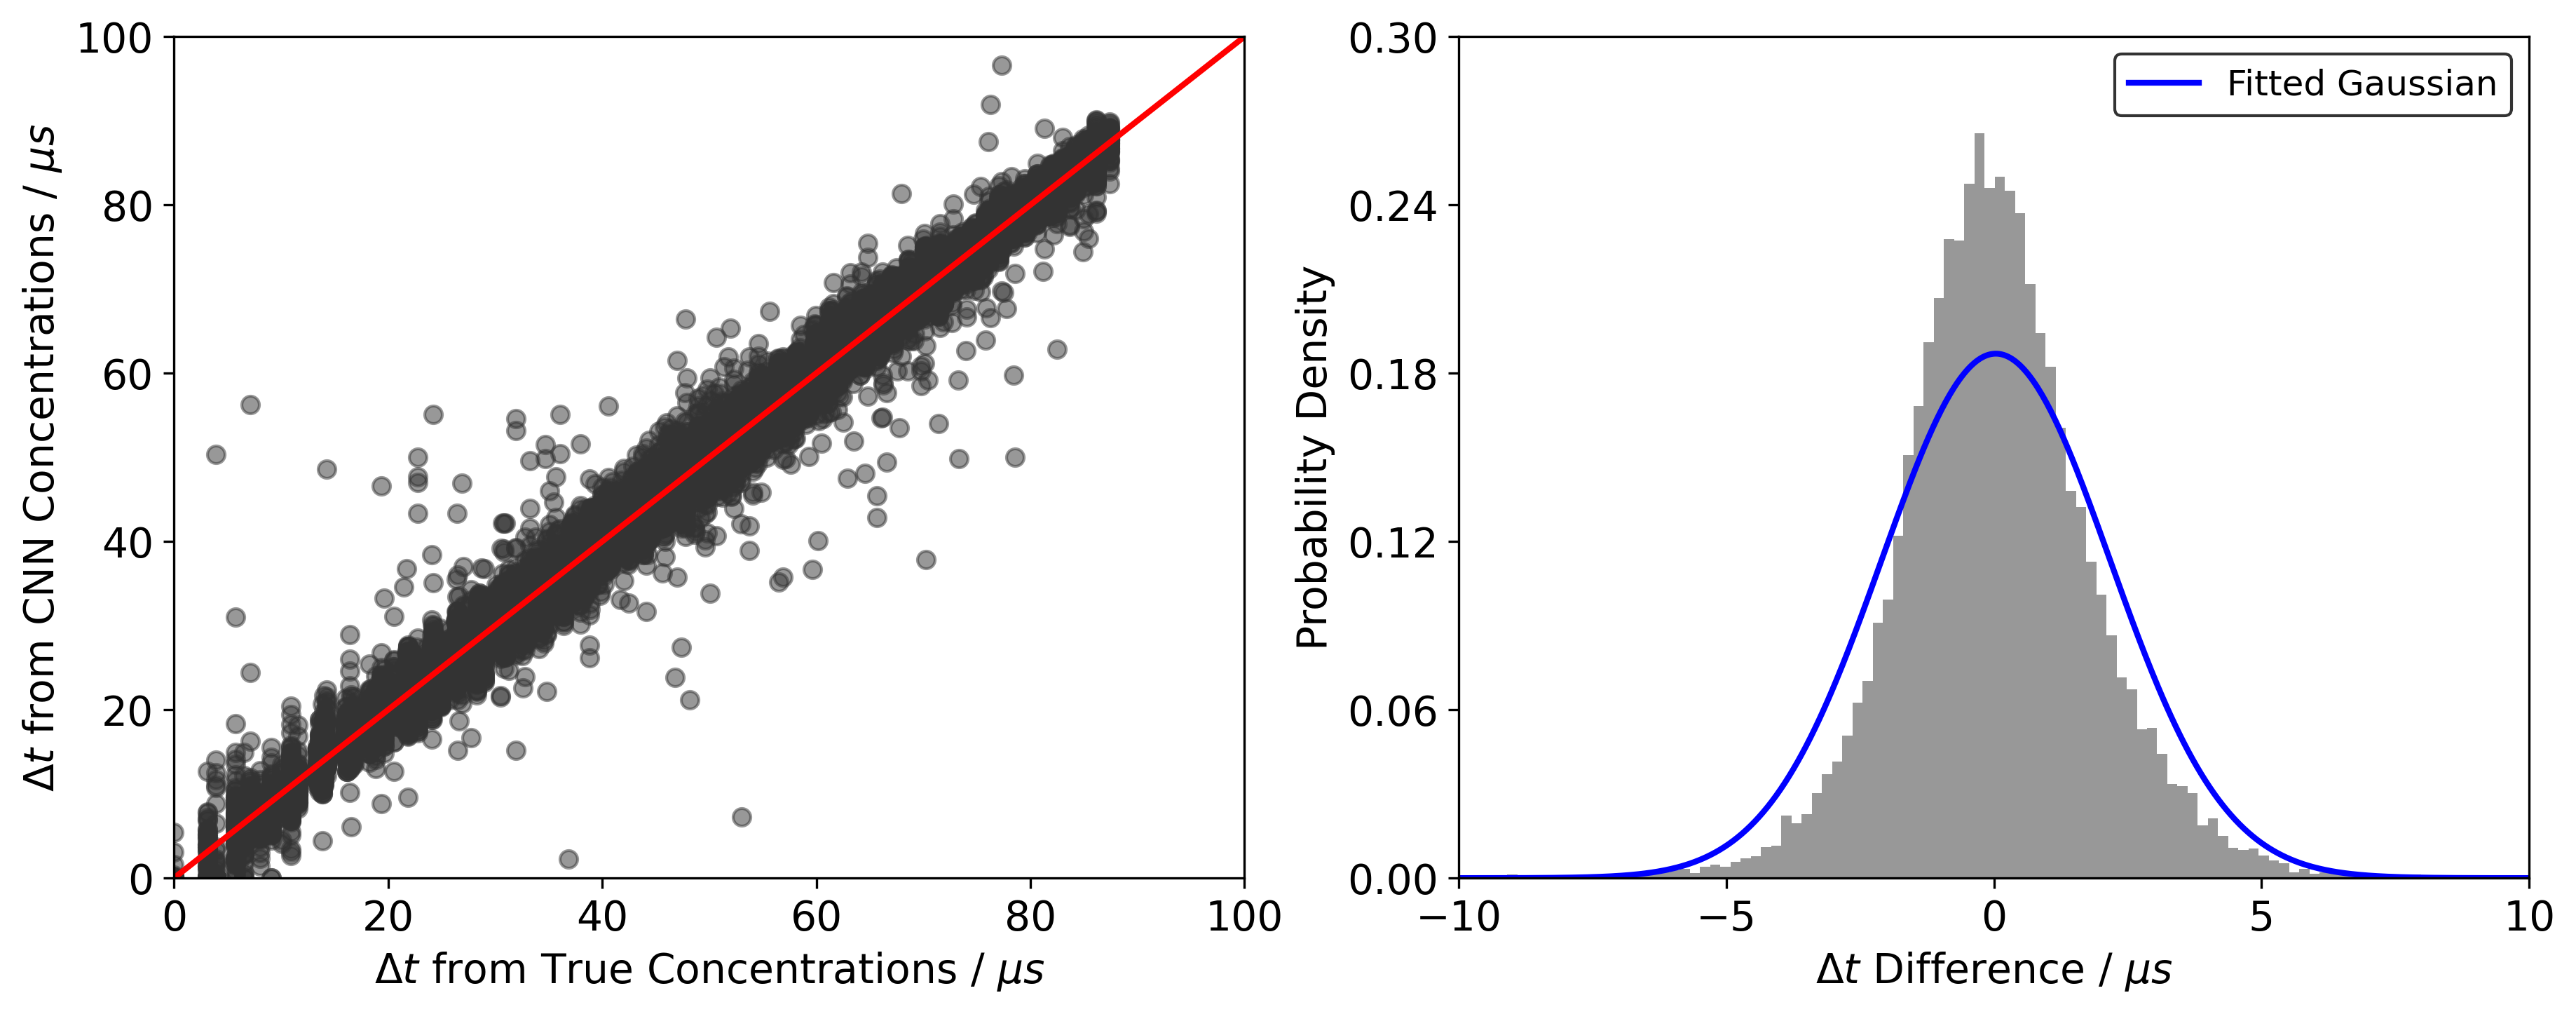

In [ ]:
from scipy.stats import norm

nr = 1
nc = 2

plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('font',**{'family':'serif','serif':['Times']})
fig, ax  = plt.subplots(nr,nc,figsize=(7*nc,5*nr),dpi=300)
fig.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.2,hspace=0.4)
ax = ax.flatten()
kwargs = dict(alpha=0.5, bins=500)

for idx in range(nr*nc):
  if idx == 0:
    ax[idx].scatter(TOF_True,TOF_CNN,fc=(.2, .2, .2, 0.5))
    ax[idx].plot([0,100],[0,100],color = 'r',linewidth = 2,zorder=1)
    ax[idx].set_ylabel('$\Delta t$ from CNN Concentrations / $\mu s$', fontsize=14)
    ax[idx].set_xlabel('$\Delta t$ from True Concentrations / $\mu s$', fontsize=14)
    ax[idx].set_ylim(0,100);ax[idx].set_xlim(0,100)
  else:
    ax[idx].hist(Diff, **kwargs,fc=(.2, .2, .2, 0.5),density=True)
    mu_1, std_1 = norm.fit(Diff)
    x_1 = np.linspace(-10,10,500)
    p_1 = norm.pdf(x_1, mu_1, std_1)
    ax[idx].plot(x_1, p_1, 'b', linewidth=2,label='Fitted Gaussian')
    ax[idx].set_ylim(0,0.3);ax[idx].set_xlim(-10,10)
    ax[idx].set_yticks(np.arange(0, 0.36, 0.06))
    ax[idx].set_xticks(np.arange(-10, 15, 5))
    ax[idx].set_xlabel('$\Delta t$ Difference / $\mu s$', fontsize=14)
    ax[idx].set_ylabel('Probability Density', fontsize=14)
    ax[idx].legend(loc='upper right',edgecolor='k',fontsize=12,frameon=True,ncol=1)

In [ ]:
D = predi_concen_set - Concen_test
difference_Argon = D[:,0]
difference_Air = D[:,1]
print(np.mean(difference_Air,axis=0))
print(np.std(difference_Air,axis=0))

0.02863530160797029
0.9545144023582255


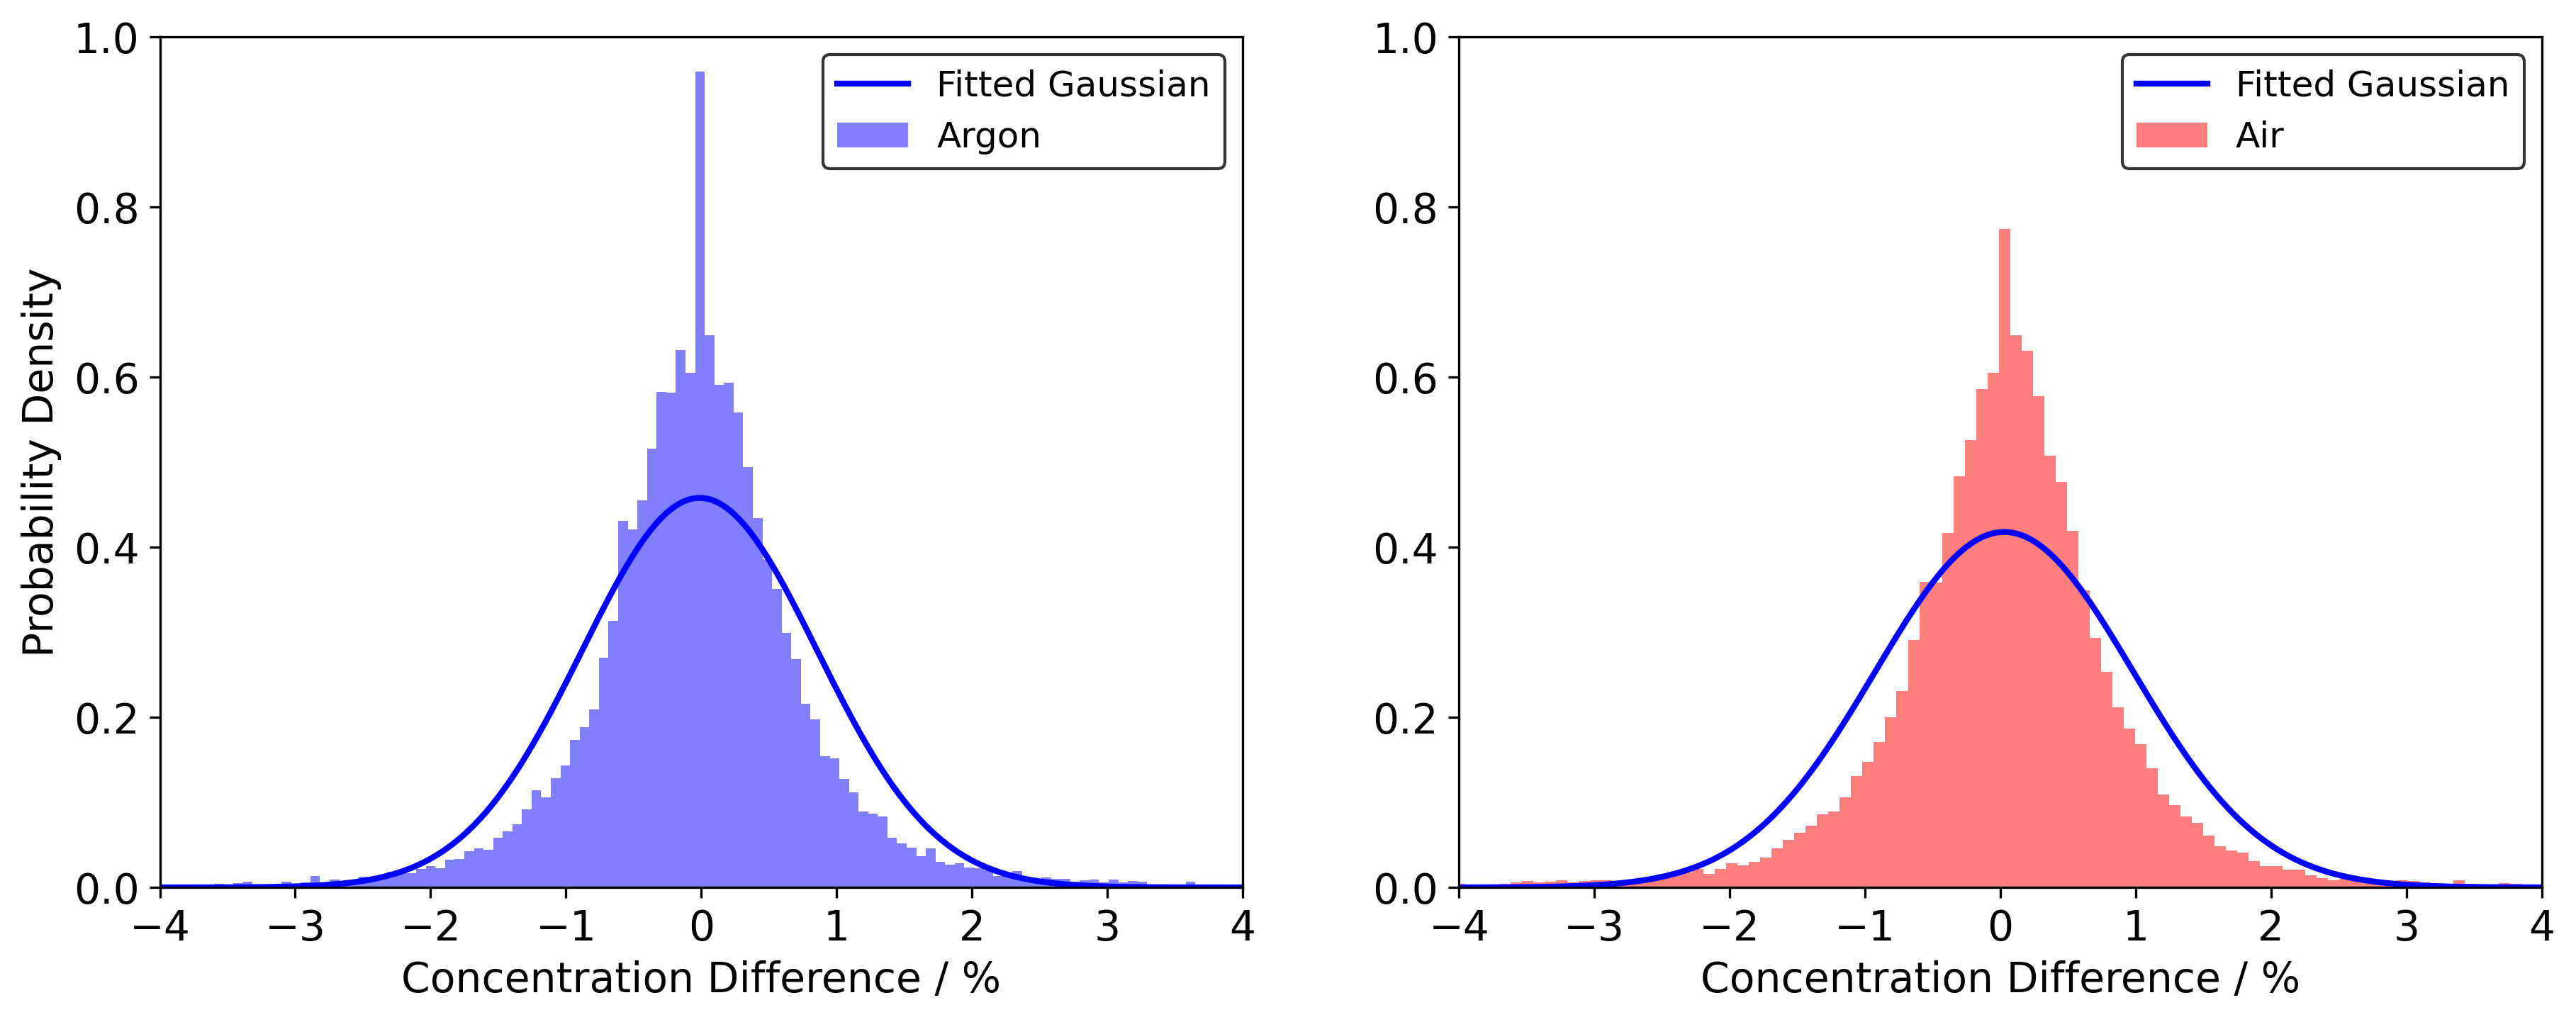

In [ ]:
from scipy.stats import norm

nr = 1
nc = 2

plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('font',**{'family':'serif','serif':['Times']})
fig, ax  = plt.subplots(nr,nc,figsize=(7*nc,5*nr),dpi=300)
fig.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.2,hspace=0.4)
ax = ax.flatten()
kwargs = dict(alpha=0.5, bins=200)

for idx in range(nr*nc):
  if idx == 0:
    ax[idx].hist(difference_Argon, **kwargs,color = 'b',label='Argon',density=True)
    ax[idx].set_ylabel('Probability Density', fontsize=14)
    mu, std = norm.fit(difference_Argon)
    x = np.linspace(-5,5, 500)
    p = norm.pdf(x, mu, std)
    ax[idx].plot(x, p, 'b', linewidth=2,label='Fitted Gaussian')

  else:
    ax[idx].hist(difference_Air, **kwargs,color = 'r',label='Air',density=True)
    mu_1, std_1 = norm.fit(difference_Air)
    x_1 = np.linspace(-4,4,500)
    p_1 = norm.pdf(x_1, mu_1, std_1)
    ax[idx].plot(x_1, p_1, 'b', linewidth=2,label='Fitted Gaussian')

  ax[idx].set_ylim(0,1)
  ax[idx].set_xlim(-4,4)
  ax[idx].set_xlabel('Concentration Difference / %', fontsize=14)
  ax[idx].legend(loc='upper right',edgecolor='k',fontsize=12,frameon=True,ncol=1)

Text(0, 0.5, 'Predicted TOF / $\\mu s$')

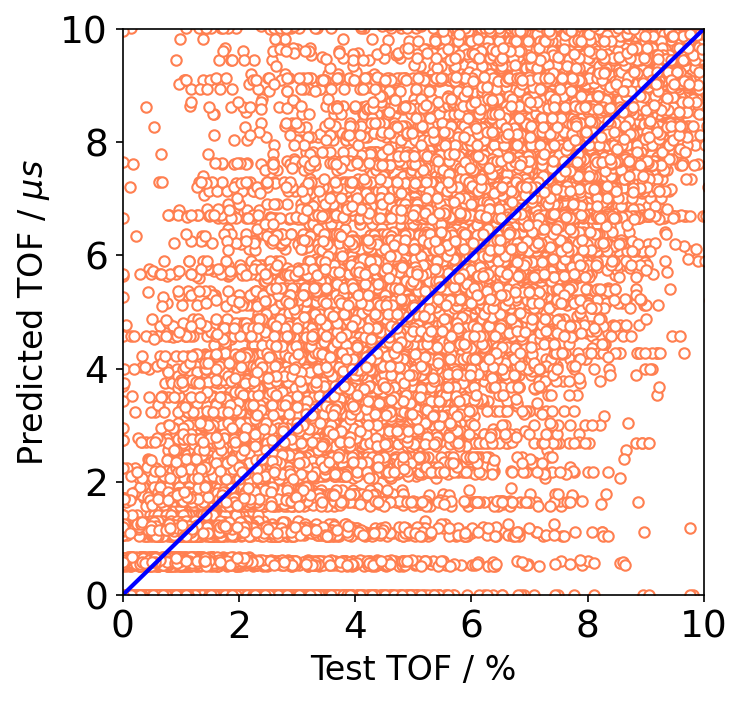

In [ ]:

plt.figure(figsize=(5,5),dpi=150)  # Figure size
mpl.rcParams.update({'font.size': 18})  # Global font size
mpl.rc('font',family='Times New Roman') # Global font style

plt.plot([0,10],[0,10],color = 'b',linewidth = 2,zorder=1)
#plt.plot([0,300],[-2,298],color = 'k',linewidth = 1,zorder=1)
#plt.plot([0,300],[2,302],color = 'k',linewidth = 1,zorder=1)
plt.scatter(predi_concen_set[:,1],Concen_test[:,1],edgecolors='coral',facecolors='white',s=25,label='True Response')

#plt.fill_between([0,300], [-2,298], [2,302], facecolor="r", alpha=0.5)
plt.xlim(0,10)
plt.ylim(0,10)
plt.xticks(np.arange(0, 12, 2))
plt.yticks(np.arange(0, 12, 2))
plt.xlabel('Test TOF / %',fontsize=16)
plt.ylabel('Predicted TOF / $\mu s$',fontsize=16)

# Load Additional Concentration outside of the training/testing

In [ ]:
%cd /content/gdrive/MyDrive/AME508/Helium-Data/20230113_TwoImpurityTEST_WithoutPlates

/content/gdrive/MyDrive/AME508/Helium-Data/20230113_TwoImpurityTEST_WithoutPlates


In [ ]:
Addi_Excitation_set = np.load('Additional_Ex+Concen.npy') # 2351 is the # of samples, 251 is the length
Addi_Response_set = np.load('Additional_Response_set.npy') # 351 is the length
Addi_Concen_set = np.load('Additional_Concen.npy')

Ts = 2e-7 # sampling interval
Time_exci = np.arange(0, 50e-6+Ts/2, Ts)
Time_response = np.arange(145e-6, 300e-6+Ts/2, Ts)

In [ ]:
# REMOVE those random shift by equipment
idx_to_delet = np.argwhere(Addi_Excitation_set[:,0]>0.1)
Addi_Excitation_set = np.delete(Addi_Excitation_set,idx_to_delet,axis=0)
Addi_Response_set = np.delete(Addi_Response_set,idx_to_delet,axis=0)
Addi_Concen_set = np.delete(Addi_Concen_set,idx_to_delet,axis=0)

In [ ]:
Ex_set_zeropad = np.pad(Addi_Excitation_set[:,:-2], ((0,0),(0,525)), 'constant')
Input_resp_ex = np.column_stack((Addi_Response_set,Ex_set_zeropad))

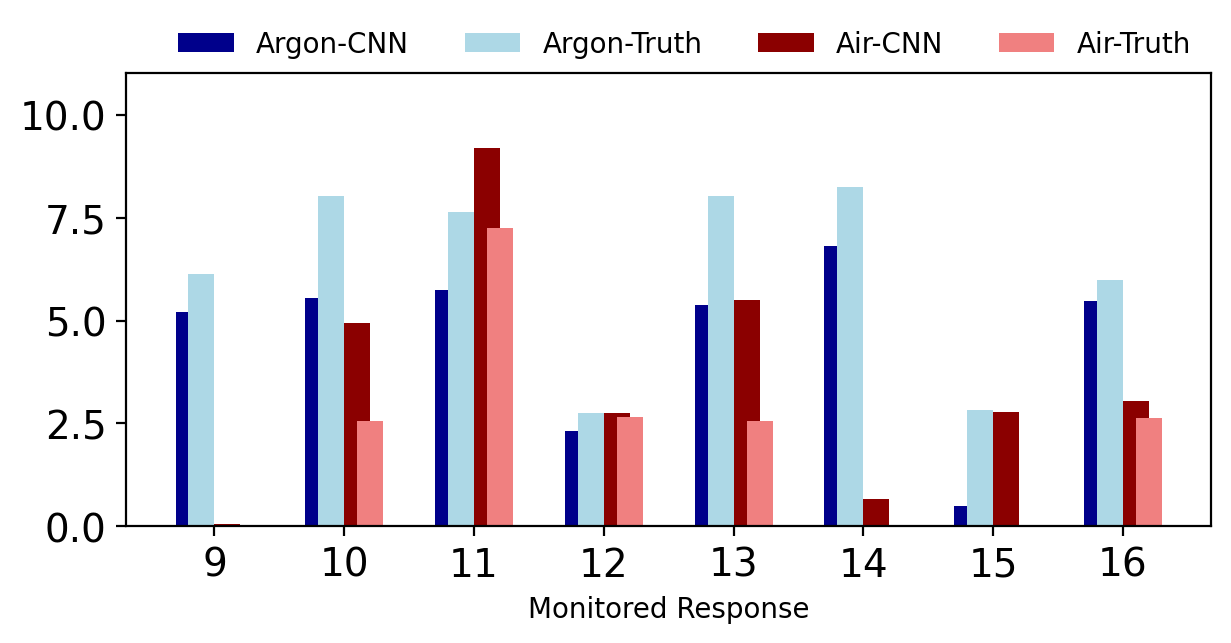

In [ ]:
truth = test_prediction = np.zeros((1,2))

for i in range(8):
  Wave_idx = np.random.randint(Input_resp_ex.shape[0])
  test_wave = Input_resp_ex[Wave_idx:Wave_idx+1,:]
  truth = np.append(truth,Addi_Concen_set[Wave_idx:Wave_idx+1,:],axis=0)

  with torch.no_grad():
    test = torch.from_numpy(test_wave).to(torch.float32).to(device)
    test_prediction = np.append(test_prediction,cnn(test.reshape((1,2,776))).cpu().detach().numpy(),axis=0)

test_prediction = np.delete(test_prediction,0,0)
truth = np.delete(truth,0,0)

plt.figure(figsize=(7,3),dpi=200)  # Figure size
mpl.rc('font',family='Times New Roman') # Global font style

X_Name = np.arange(9,17,1).astype(str)

Value_1 = test_prediction[:,0]  # Argon-CNN
Value_2 = truth[:,0]  # Argon-Truth
Value_3 = test_prediction[:,1]  # Air-CNN
Value_4 = truth[:,1]  # Air-Truth

bar_width = 0.2 # width
Index_first = np.arange(len(X_Name))
index_second = Index_first + 0.5*bar_width
Index_third = Index_first + 1.5*bar_width
index_forth = Index_first + 2*bar_width

p1 = plt.bar(Index_first, height=Value_1, width=bar_width, color='darkblue',label='Argon-CNN')
p2 = plt.bar(index_second, height=Value_2, width=bar_width, color='lightblue', label='Argon-Truth')
p3 = plt.bar(Index_third, height=Value_3, width=bar_width, color='darkred',label='Air-CNN')
p4 = plt.bar(index_forth, height=Value_4, width=bar_width, color='lightcoral', label='Air-Truth')

plt.xticks(Index_first + bar_width, X_Name)

plt.legend(loc='upper left',edgecolor='b',fontsize='medium',bbox_to_anchor=(0.025,1.15),frameon=False,ncol=4)
plt.ylim(0,11)   # y-limit
#plt.ylabel("Impurity Concentration / %")
plt.xlabel("Monitored Response")
plt.savefig('Application-2.svg',format='svg',bbox_inches = 'tight')
'''
ax = plt.gca()
plt.bar_label(p1,fontsize = 25, fmt='%g', padding=5,rotation=90)
ax.bar_label(p2,fontsize = 25,fmt='%g',padding=5,rotation=90)
'''
plt.show()

In [ ]:
predi_concen_set = np.zeros((1,2))
for Wave_idx in range(Input_resp_ex.shape[0]):
  with torch.no_grad():
    test = torch.from_numpy(Input_resp_ex[Wave_idx:Wave_idx+1,:]).to(torch.float32).to(device)
    test_prediction = cnn(test.reshape((1,2,776))).cpu().detach().numpy()
    predi_concen_set = np.append(predi_concen_set, test_prediction,axis=0)

predi_concen_set = np.delete(predi_concen_set,0,0)
print(predi_concen_set.shape)

TOF_CNN = TOF_True = np.zeros(0,)
for idx in range(len(predi_concen_set)):

  TOF_CNN = np.append(TOF_CNN,Cal_deltaTOF(predi_concen_set[idx,0],predi_concen_set[idx,1]))
  TOF_True = np.append(TOF_True,Cal_deltaTOF(Addi_Concen_set[idx,0],Addi_Concen_set[idx,1]))

Diff = TOF_CNN - TOF_True

(1809, 2)


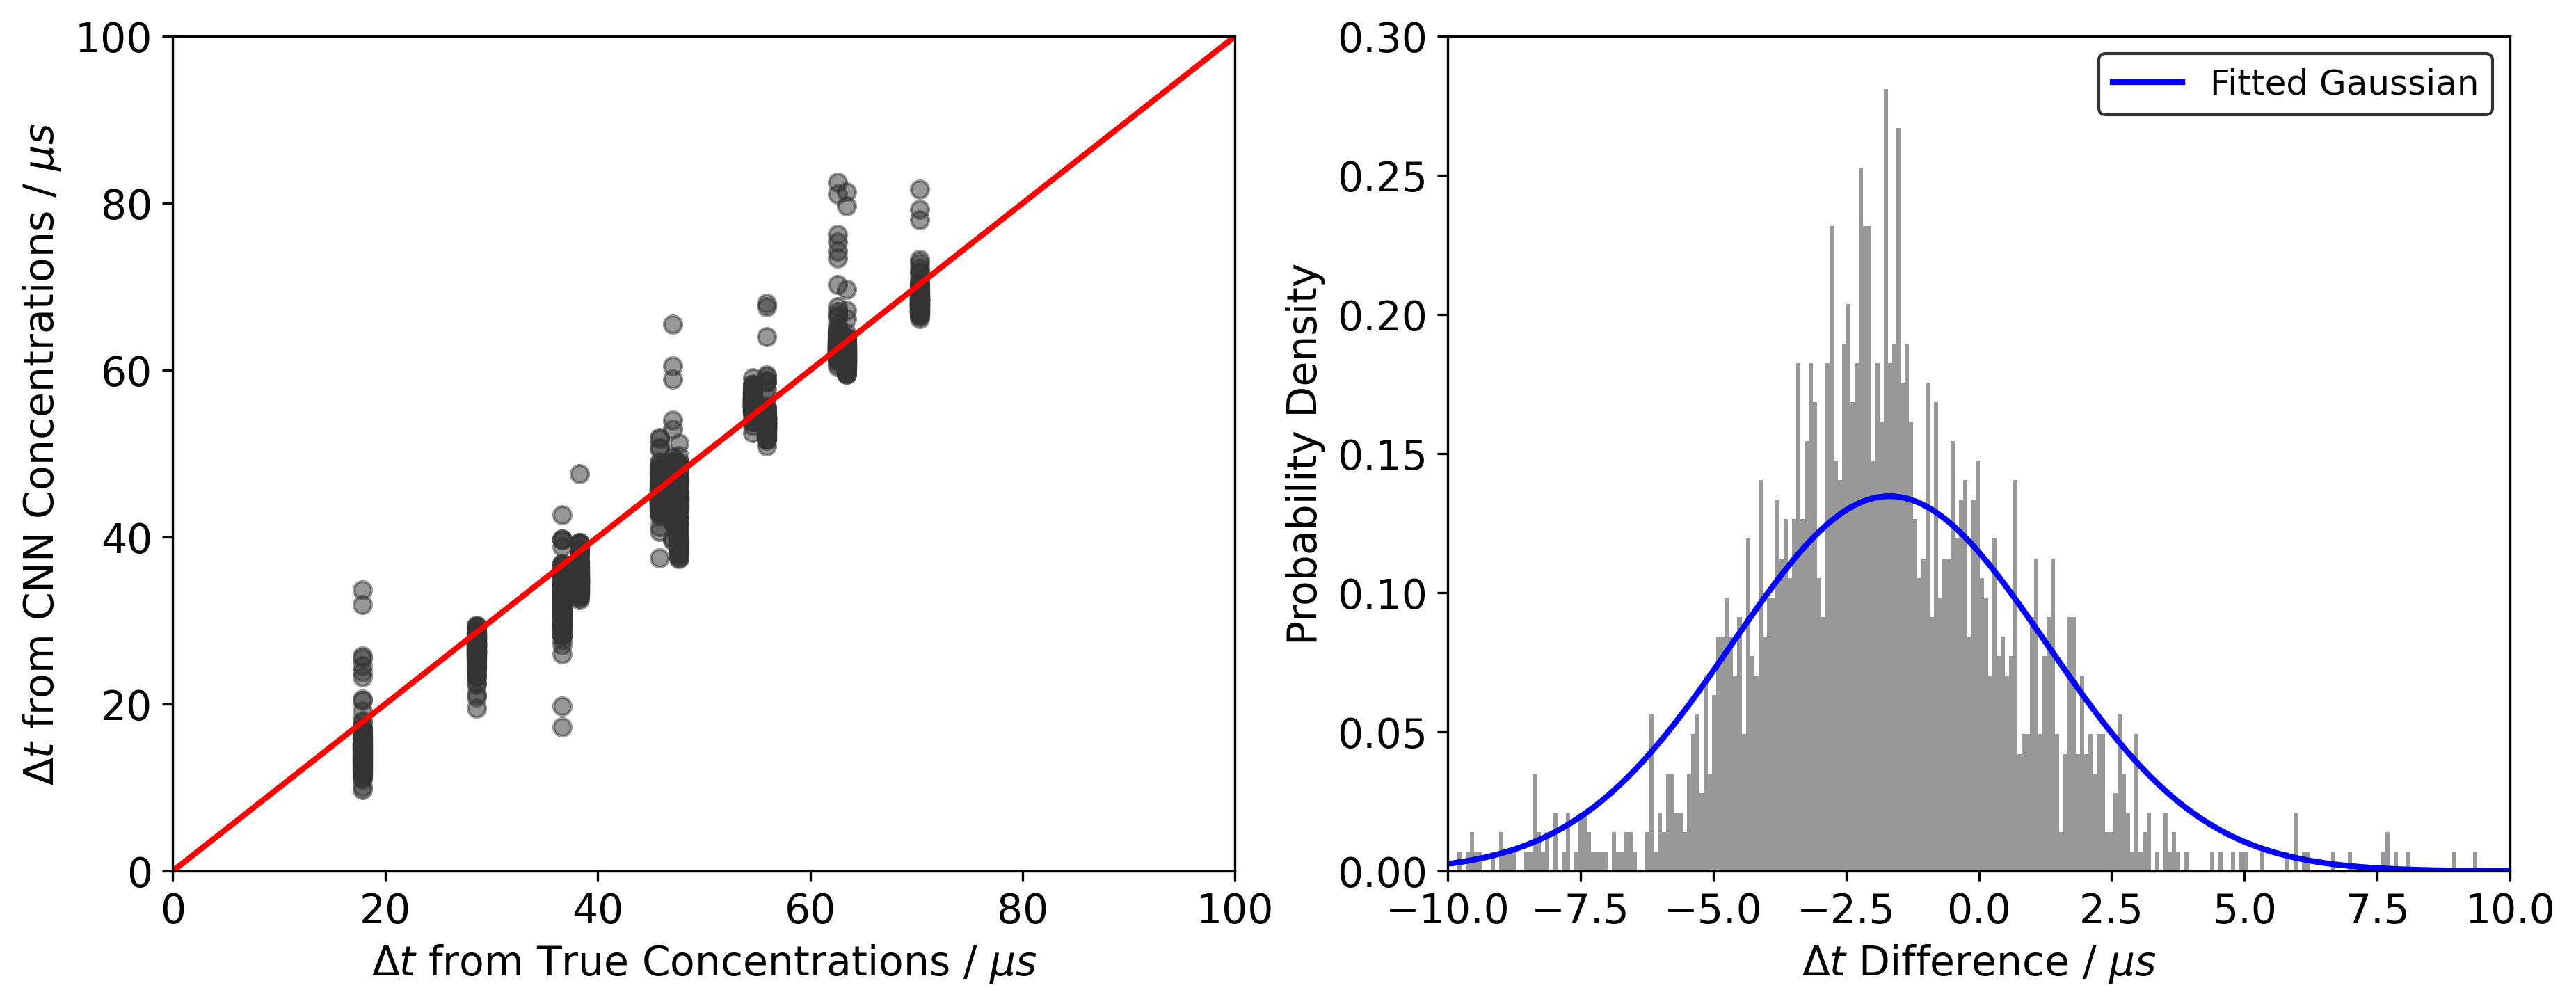

In [ ]:
from scipy.stats import norm

nr = 1
nc = 2

plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('font',**{'family':'serif','serif':['Times']})
fig, ax  = plt.subplots(nr,nc,figsize=(7*nc,5*nr),dpi=300)
fig.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.2,hspace=0.4)
ax = ax.flatten()
kwargs = dict(alpha=0.5, bins=500)

for idx in range(nr*nc):
  if idx == 0:
    ax[idx].scatter(TOF_True,TOF_CNN,fc=(.2, .2, .2, 0.5))
    ax[idx].plot([0,100],[0,100],color = 'r',linewidth = 2,zorder=1)
    ax[idx].set_ylabel('$\Delta t$ from CNN Concentrations / $\mu s$', fontsize=14)
    ax[idx].set_xlabel('$\Delta t$ from True Concentrations / $\mu s$', fontsize=14)
    ax[idx].set_ylim(0,100);ax[idx].set_xlim(0,100)
  else:
    ax[idx].hist(Diff, **kwargs,fc=(.2, .2, .2, 0.5),density=True)
    mu_1, std_1 = norm.fit(Diff)
    x_1 = np.linspace(-10,10,500)
    p_1 = norm.pdf(x_1, mu_1, std_1)
    ax[idx].plot(x_1, p_1, 'b', linewidth=2,label='Fitted Gaussian')
    ax[idx].set_ylim(0,0.3);ax[idx].set_xlim(-10,10)
    ax[idx].set_xlabel('$\Delta t$ Difference / $\mu s$', fontsize=14)
    ax[idx].set_ylabel('Probability Density', fontsize=14)
    ax[idx].legend(loc='upper right',edgecolor='k',fontsize=12,frameon=True,ncol=1)

In [ ]:
D = predi_concen_set - Addi_Concen_set
difference_Argon = D[:,0]
difference_Air = D[:,1]
print(np.mean(difference_Air,axis=0))
print(np.std(difference_Air,axis=0))

0.9924020108285972
1.8959709679920909


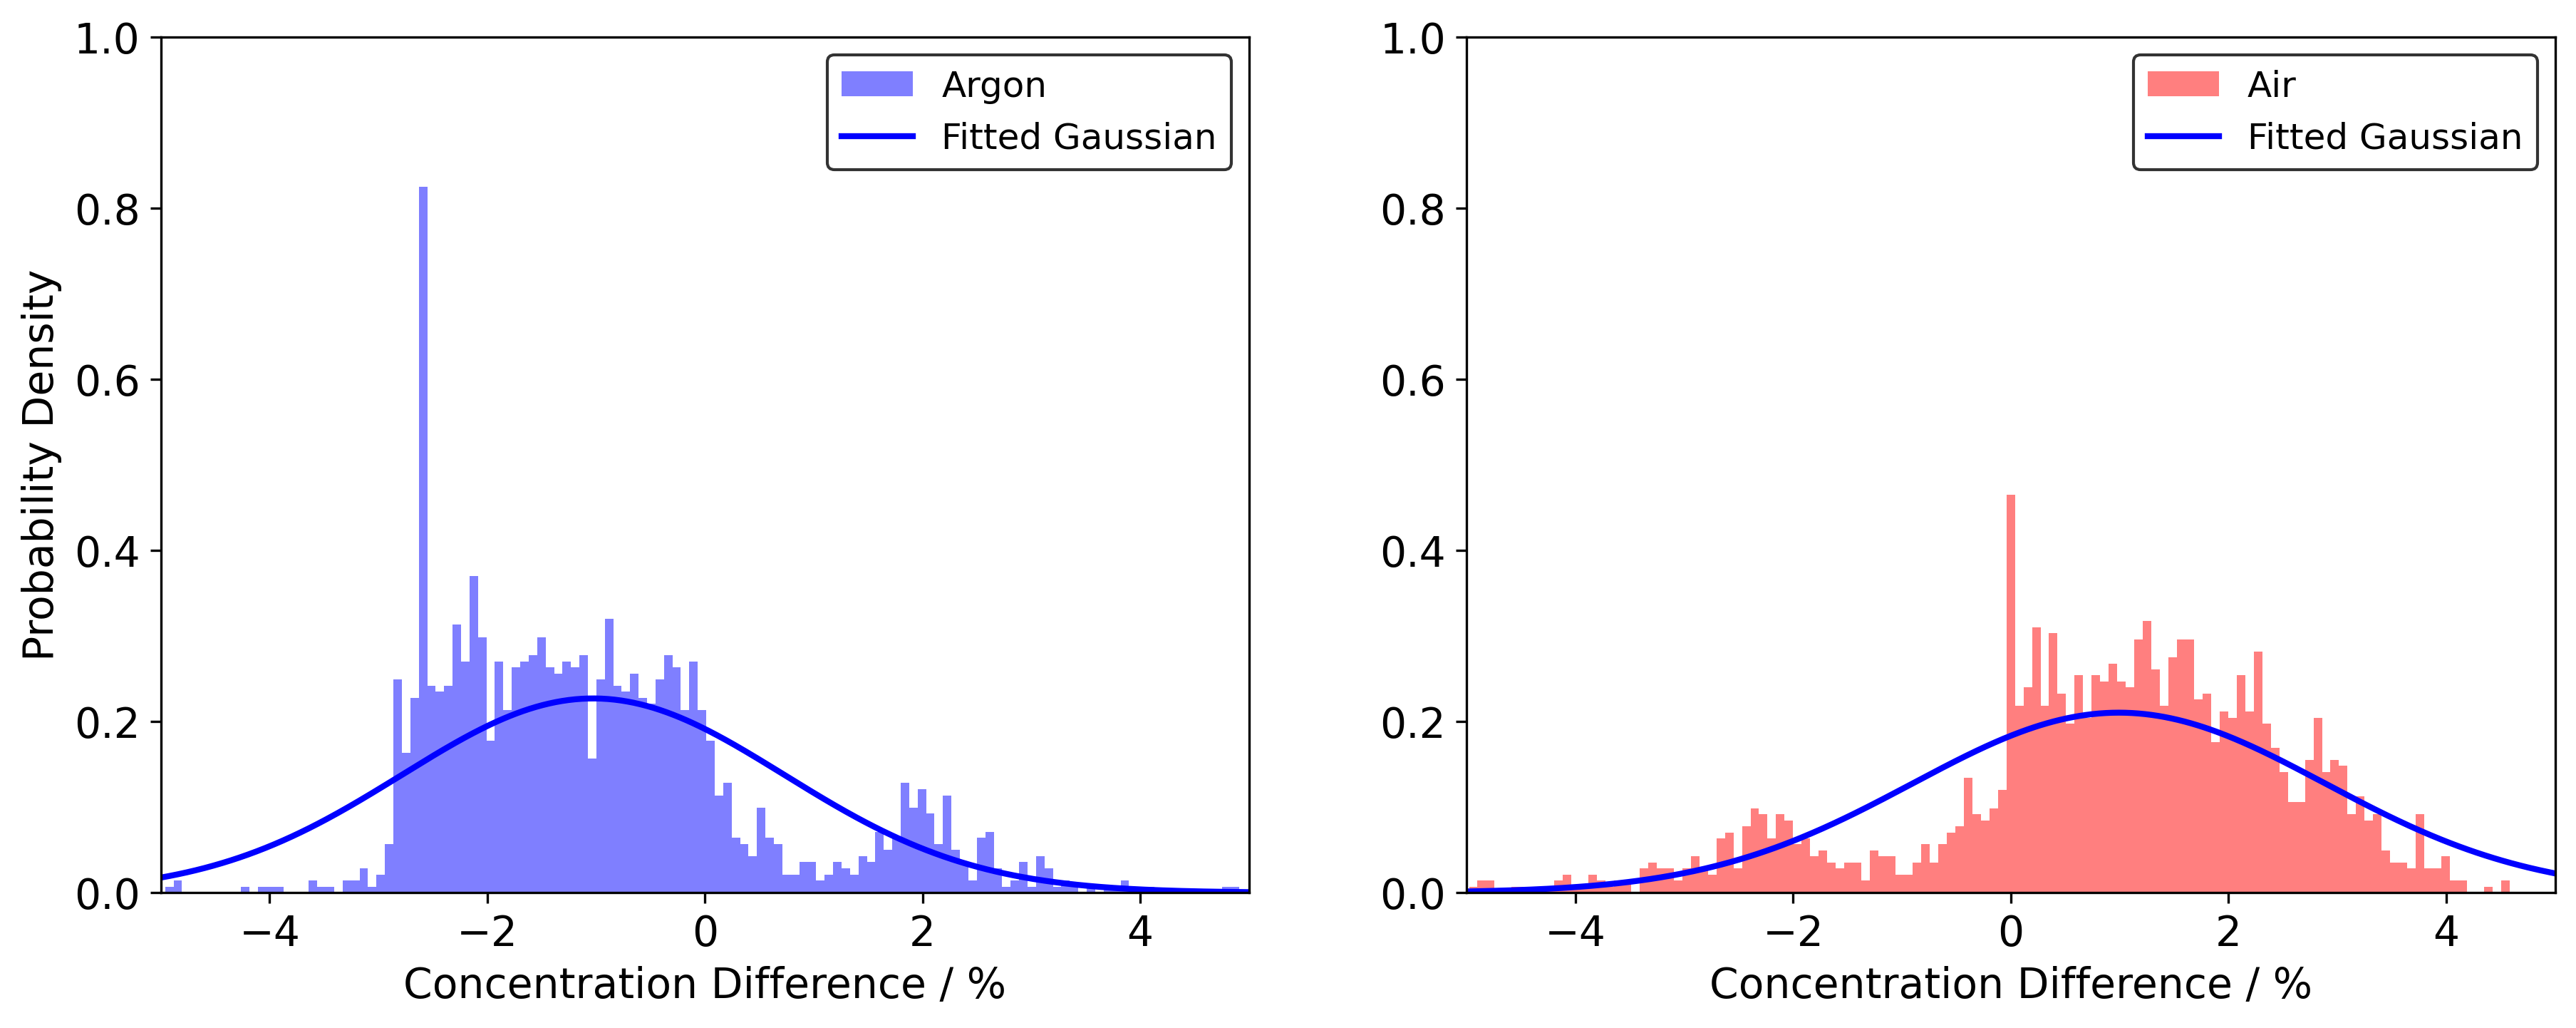

In [ ]:
from scipy.stats import norm

nr = 1
nc = 2

plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('font',**{'family':'serif','serif':['Times']})
fig, ax  = plt.subplots(nr,nc,figsize=(7*nc,5*nr),dpi=300)
fig.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.2,hspace=0.4)
ax = ax.flatten()
kwargs = dict(alpha=0.5, bins=200)

for idx in range(nr*nc):
  if idx == 0:
    ax[idx].hist(difference_Argon, **kwargs,color = 'b',label='Argon',density=True)
    ax[idx].set_ylabel('Probability Density', fontsize=14)
    mu, std = norm.fit(difference_Argon)
    x = np.linspace(-5,5, 500)
    p = norm.pdf(x, mu, std)
    ax[idx].plot(x, p, 'b', linewidth=2,label='Fitted Gaussian')

  else:
    ax[idx].hist(difference_Air, **kwargs,color = 'r',label='Air',density=True)
    mu_1, std_1 = norm.fit(difference_Air)
    x_1 = np.linspace(-5,5,500)
    p_1 = norm.pdf(x_1, mu_1, std_1)
    ax[idx].plot(x_1, p_1, 'b', linewidth=2,label='Fitted Gaussian')

  ax[idx].set_ylim(0,1)
  ax[idx].set_xlim(-5,5)
  ax[idx].set_xlabel('Concentration Difference / %', fontsize=14)
  ax[idx].legend(loc='upper right',edgecolor='k',fontsize=12,frameon=True,ncol=1)
plt.savefig('Difference-histogram.svg',format='svg',bbox_inches = 'tight')